# 기본

In [3]:
#모듈 호출

import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats as spst
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")  # matplotlib style 설정

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [5]:
#csv 파일 호출

df_orders=pd.read_csv("olist_orders.csv")
df_customers=pd.read_csv('olist_customers.csv')
df_order_items=pd.read_csv('olist_order_items.csv')
df_order_payments=pd.read_csv('olist_order_payments.csv')
df_products=pd.read_csv('olist_products.csv')
df_trans=pd.read_csv('product_category_name_translation.csv')

In [6]:
#전체 병합 파일 df 생성

df_co = pd.merge(df_customers, df_orders, on='customer_id', how='left')
df_co['total_orders'] = df_co.groupby('customer_unique_id')['order_id'].transform('count')
df_coi = pd.merge(df_co, df_order_items, on="order_id", how='left')
df_coi['total_order_items'] = df_coi.groupby('customer_unique_id')['customer_unique_id'].transform('count')
df_coip = pd.merge(df_coi, df_order_payments, on="order_id", how="left")
df_product=pd.merge(df_products,df_trans,on='product_category_name',how='outer')
mask = ~df_product['product_category_name_english'].isnull()
df_product.loc[mask, 'product_category_name'] = df_product.loc[mask, 'product_category_name_english']
df = pd.merge(df_coip, df_product, on="product_id", how="left")

# 1day / ndays 구분

In [7]:
#한 번 구매한 고객 df_1 생성
df_1 = df[df['total_orders']==1]

#한 번 구매한 고객 제외 df_n 생성
df_n = df[df['total_orders']!=1]

In [8]:
df_n['order_purchase_timestamp'] = pd.to_datetime(df_n['order_purchase_timestamp'])

# 데이터를 시간 순서대로 정렬
df_n = df_n.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 각 고객별로 주문 간 시간 간격을 계산하고 'duration_days' 열에 할당
df_n['duration_days'] = df_n.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

# 첫 번째 주문의 'duration_days'를 NaN으로 처리
df_n.loc[df_n.groupby('customer_unique_id').cumcount() == 0, 'duration_days'] = pd.NaT
df_n['order_purchase_timestamp'] = pd.to_datetime(df_n['order_purchase_timestamp'])

# 데이터를 시간 순서대로 정렬
df_n = df_n.sort_values(by=['customer_unique_id', 'order_purchase_timestamp'])

# 각 고객별로 주문 간 시간 간격을 계산하고 'duration_days' 열에 할당
df_n['duration_days'] = df_n.groupby('customer_unique_id')['order_purchase_timestamp'].diff().dt.days

# 첫 번째 주문의 'duration_days'를 NaN으로 처리
df_n.loc[df_n.groupby('customer_unique_id').cumcount() == 0, 'duration_days'] = pd.NaT


In [9]:
df_n.groupby('customer_unique_id').size()

customer_unique_id
00172711b30d52eea8b313a7f2cced02    2
004288347e5e88a27ded2bb23747066c    2
004b45ec5c64187465168251cd1c9c2f    2
0058f300f57d7b93c477a131a59b36c3    3
00a39521eb40f7012db50455bf083460    2
                                   ..
ff36be26206fffe1eb37afd54c70e18b    3
ff44401d0d8f5b9c54a47374eb48c1b8    4
ff8892f7c26aa0446da53d01b18df463    2
ff922bdd6bafcdf99cb90d7f39cea5b3    3
ffe254cc039740e17dd15a5305035928    2
Length: 2997, dtype: int64

# n_ndays / n_1day 구분

In [10]:
#Nan 값과 하루에 많이 주문한 고객 제외
df_duration=df_n[df_n['duration_days']!=0]
df_duration = df_duration.dropna(subset=['duration_days'])

df_n_ndays = df_duration.copy()

In [11]:
#단일 방문 n번 구매한 적이 있는 그룹 'df_n_1day': 1549명 -> 877명
df_n_1day=df_n[df_n['duration_days']<=0]
villain=list(set(df_duration['customer_unique_id']).intersection(set(df_n_1day['customer_unique_id'])))
df_n_1day=df_n_1day[~df_n_1day['customer_unique_id'].isin(villain)]

In [12]:
df_1.groupby('customer_unique_id').size()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Length: 93099, dtype: int64

---

---

# 이탈/잠재 만들기

In [13]:
df_n_1day.drop('duration_days',axis=1,inplace=True)

df_1day=pd.concat([df_1, df_n_1day])
df_1day

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,1.0,credit_card,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,1.0,credit_card,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,1.0,credit_card,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,1.0,credit_card,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,1.0,credit_card,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15437,70a9b3a2a2f6c0e8cc4852bc3a591e2e,fed2005ccab4fcf1a40ebdaff032a148,13870,02b0bf9164ac7753f9880e46dba17f6c,delivered,2022-06-17 17:04:31,2022-06-17 17:15:21,2022-06-30 12:22:11,2022-07-07 00:00:00,2,...,1.0,credit_card,1.0,63.42,computers_accessories,75.0,17.0,6.0,58.0,computers_accessories
18460,5d0c6c3c37720178553332f2509b2568,ff44401d0d8f5b9c54a47374eb48c1b8,13070,c087855fe6f303205c09558f7f8103c8,delivered,2022-05-19 21:20:54,2022-05-19 21:35:16,2022-06-01 18:05:18,2022-06-12 00:00:00,2,...,2.0,voucher,1.0,28.47,fashion_bags_accessories,200.0,16.0,9.0,11.0,fashion_bags_accessories
105234,09c682ef897935e677a0996cfe2008f3,ff44401d0d8f5b9c54a47374eb48c1b8,13070,e28a4c66f1484567d1e42b3fab64d923,delivered,2022-05-19 21:20:54,2022-05-19 21:42:44,2022-05-31 17:06:38,2022-06-23 00:00:00,2,...,1.0,credit_card,1.0,0.72,fashion_bags_accessories,150.0,16.0,9.0,11.0,fashion_bags_accessories
105235,09c682ef897935e677a0996cfe2008f3,ff44401d0d8f5b9c54a47374eb48c1b8,13070,e28a4c66f1484567d1e42b3fab64d923,delivered,2022-05-19 21:20:54,2022-05-19 21:42:44,2022-05-31 17:06:38,2022-06-23 00:00:00,2,...,2.0,voucher,1.0,38.28,fashion_bags_accessories,150.0,16.0,9.0,11.0,fashion_bags_accessories


In [14]:

df_1day.groupby('customer_unique_id').size()

customer_unique_id
0000366f3b9a7992bf8c76cfdf3221e2    1
0000b849f77a49e4a4ce2b2a4ca5be3f    1
0000f46a3911fa3c0805444483337064    1
0000f6ccb0745a6a4b88665a16c9f078    1
0004aac84e0df4da2b147fca70cf8255    1
                                   ..
fffcf5a5ff07b0908bd4e2dbc735a684    2
fffea47cd6d3cc0a88bd621562a9d061    1
ffff371b4d645b6ecea244b27531430a    1
ffff5962728ec6157033ef9805bacc48    1
ffffd2657e2aad2907e67c3e9daecbeb    1
Length: 93976, dtype: int64

In [15]:
df_ndays=df_n_ndays

In [16]:
df_ndays.groupby('customer_unique_id').size()

customer_unique_id
00172711b30d52eea8b313a7f2cced02    1
004288347e5e88a27ded2bb23747066c    1
004b45ec5c64187465168251cd1c9c2f    1
0058f300f57d7b93c477a131a59b36c3    1
00a39521eb40f7012db50455bf083460    1
                                   ..
ff03923ad1eb9e32304deb7f9b2a45c9    1
ff22e30958c13ffe219db7d711e8f564    1
ff36be26206fffe1eb37afd54c70e18b    2
ff8892f7c26aa0446da53d01b18df463    1
ff922bdd6bafcdf99cb90d7f39cea5b3    2
Length: 2120, dtype: int64

In [17]:
from datetime import datetime

standard=datetime(2023, 8, 11, 0, 0, 0)

df_1day['order_purchase_timestamp'] = pd.to_datetime(df_1day['order_purchase_timestamp'])

#기준시보다 크거나 같으면 poten
df_poten=df_1day[df_1day['order_purchase_timestamp'] >= standard]

In [18]:
poten=list(set(df_poten['customer_unique_id']))
df_churn=df_1day[~df_1day['customer_unique_id'].isin(poten)]

# 데이터 정리

- df_1day: 하루에 구매한 고객 (우리가 전에 정한 Target)
- df_ndays: 여러번 반복 구매한 고객 (우리가 전에 정한 Sample)
- df_n_1day: 하루에 여러번 구매한 고객
- df_n_ndays: 여러날에 여러번 구매한 고객

- df_poten: 잠재고객(Target 중 돌아올 있는 가능성)
- df_churn: 이미 떠난 이탈 고객(Target 중 돌아올 X)

# 데이터 전처리

## 결측치 확인

In [19]:
df.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_customer_date    3397
order_estimated_delivery_date       0
total_orders                        0
product_id                        830
seller_id                         830
price                             830
freight_value                     830
total_order_items                   0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
product_category_name            2528
product_weight_g                  850
product_length_cm                 850
product_height_cm                 850
product_width_cm                  850
product_category_name_english    2553
dtype: int64

## 이상치 확인

<Axes: ylabel='freight_value'>

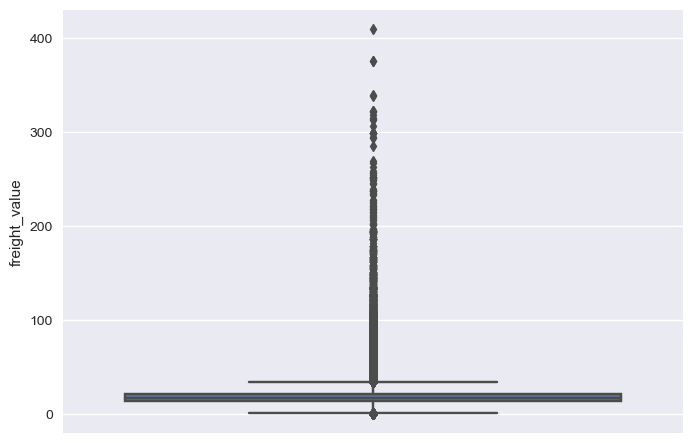

In [20]:
sns.boxplot(data = df, y = 'freight_value')

<Axes: ylabel='product_length_cm'>

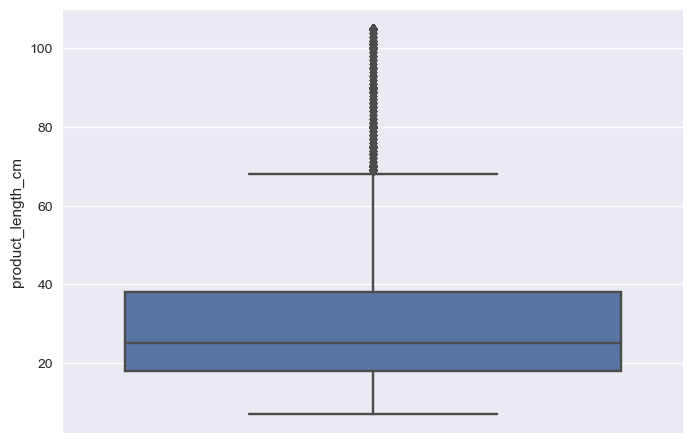

In [21]:
sns.boxplot(data = df, y = 'product_length_cm')

<Axes: ylabel='price'>

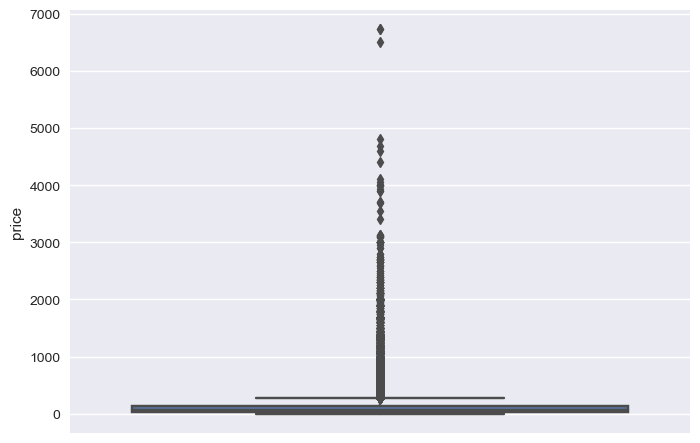

In [22]:
sns.boxplot(data = df, y = 'price')

## seller 별 판매 카테고리 비중

In [23]:
df['seller_id'].value_counts()

seller_id
4a3ca9315b744ce9f8e9374361493884    2133
6560211a19b47992c3666cc44a7e94c0    2122
1f50f920176fa81dab994f9023523100    2008
cc419e0650a3c5ba77189a1882b7556a    1847
da8622b14eb17ae2831f4ac5b9dab84a    1639
                                    ... 
2235cf78d3e2073a88146a9cb60f0dd0       1
b00af24704019bd2e1b335e70ad11f7c       1
c963a25b8671419c6ce9eebe8fd03218       1
0b1ca3ef18a63d7eb0c8897fa0849c08       1
5d043cd5512d4bd2f88e5ccdd5736c38       1
Name: count, Length: 3095, dtype: int64

In [24]:
seller_category = df.groupby('seller_id')['product_category_name_english'].unique()

seller_category

seller_id
0015a82c2db000af6aaaf3ae2ecb0532                                   [small_appliances]
001cca7ae9ae17fb1caed9dfb1094831      [garden_tools, construction_tools_construction]
001e6ad469a905060d959994f1b41e4f                                     [sports_leisure]
002100f778ceb8431b7a1020ff7ab48f                                    [furniture_decor]
003554e2dce176b5555353e4f3555ac8                                                [nan]
                                                          ...                        
ffcfefa19b08742c5d315f2791395ee5                             [books_general_interest]
ffdd9f82b9a447f6f8d4b91554cc7dd3                        [housewares, furniture_decor]
ffeee66ac5d5a62fe688b9d26f83f534                                    [home_appliances]
fffd5413c0700ac820c7069d66d98c89    [housewares, furniture_decor, furniture_living...
ffff564a4f9085cd26170f4732393726    [auto, nan, food, electronics, housewares, con...
Name: product_category_name_english, Length:

In [25]:
category_counts = df['product_category_name_english'].value_counts()

print("각 카테고리별 판매 수:")
print(category_counts)

각 카테고리별 판매 수:
product_category_name_english
bed_bath_table               11823
health_beauty                 9975
sports_leisure                8945
furniture_decor               8744
computers_accessories         8082
                             ...  
arts_and_craftmanship           24
la_cuisine                      16
cds_dvds_musicals               14
fashion_childrens_clothes        8
security_and_services            2
Name: count, Length: 71, dtype: int64


In [26]:
combined_categories = df.groupby('seller_id')['product_category_name_english'].apply(set)

# 전체 셀러들이 판매하는 카테고리의 종류의 수 계산
total_categories = combined_categories.explode().value_counts()

print("전체 셀러들이 판매하는 카테고리의 종류의 수:")
print(total_categories)

전체 셀러들이 판매하는 카테고리의 종류의 수:
product_category_name_english
health_beauty                492
sports_leisure               481
housewares                   468
auto                         383
furniture_decor              370
                            ... 
fashion_childrens_clothes      4
flowers                        3
la_cuisine                     2
security_and_services          2
cds_dvds_musicals              1
Name: count, Length: 71, dtype: int64


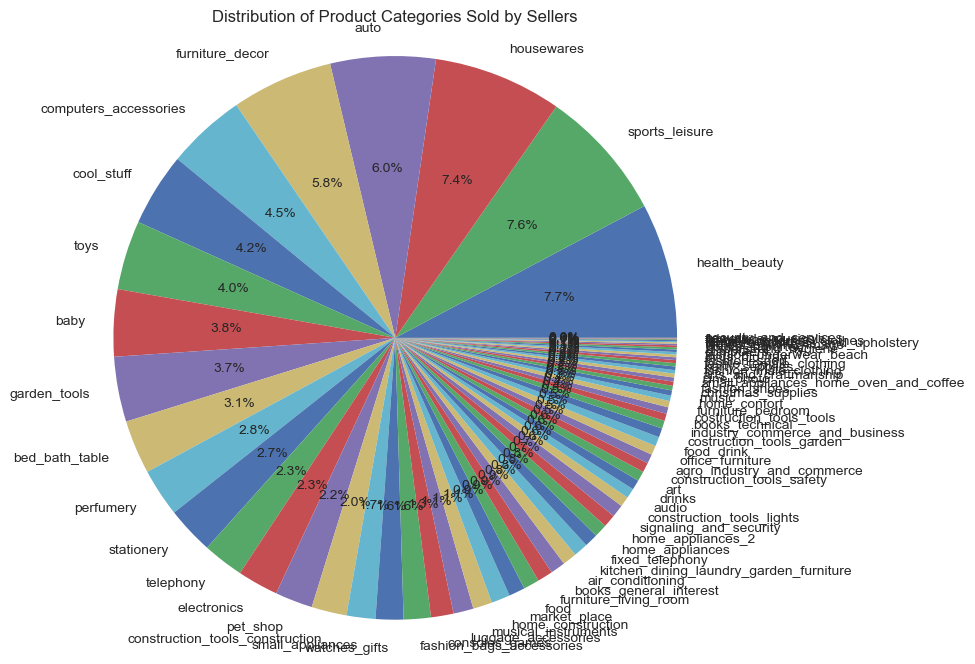

In [27]:
plt.figure(figsize=(8, 8))
plt.pie(total_categories, labels=total_categories.index, autopct='%1.1f%%')
plt.title('Distribution of Product Categories Sold by Sellers')
plt.axis('equal')
plt.show()

# 이탈 고객과 미이탈 고객 간의 비교

## 승인소요시간의 차이가 있지 않을까?
        귀무 가설(H0): 이탈 고객과 미이탈 고객 간의 평균 승인소요시간 차이가 없다. 
        대립 가설(H1): 이탈 고객과 미이탈 고객 간의 평균 승인소요시간 차이가 있다.

In [28]:
df_churn.dtypes

customer_id                              object
customer_unique_id                       object
customer_zip_code_prefix                  int64
order_id                                 object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                        object
order_delivered_customer_date            object
order_estimated_delivery_date            object
total_orders                              int64
product_id                               object
seller_id                                object
price                                   float64
freight_value                           float64
total_order_items                         int64
payment_sequential                      float64
payment_type                             object
payment_installments                    float64
payment_value                           float64
product_category_name                    object
product_weight_g                        

In [29]:
#미이탈 고객 df 만들기

churn_id = list(set(df_churn.groupby('customer_unique_id').groups.keys()))
df_id = list(set(df.groupby('customer_unique_id').groups.keys()))
df_churn_complement=df[~df['customer_unique_id'].isin(churn_id)]

In [30]:
#연산 datetime type으로 변환

df_churn['order_approved_at']=pd.to_datetime(df_churn['order_approved_at'])
df_churn_complement['order_approved_at']=pd.to_datetime(df_churn_complement['order_approved_at'])
df_churn_complement['order_purchase_timestamp']=pd.to_datetime(df_churn_complement['order_purchase_timestamp'])


In [31]:
#승인 소요 시간 칼럼 'approval_duration' 추가

approval_duration= (df_churn['order_approved_at'] - df_churn['order_purchase_timestamp']).dt.total_seconds()
approval_duration = approval_duration / 60 # 초를 분 단위로 변환
df_churn['approval_duration'] = approval_duration

approval_duration= (df_churn_complement['order_approved_at'] - df_churn_complement['order_purchase_timestamp']).dt.total_seconds()
approval_duration = approval_duration / 60 # 초를 분 단위로 변환
df_churn_complement['approval_duration'] = approval_duration

In [32]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107841 entries, 0 to 76635
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    107841 non-null  object        
 1   customer_unique_id             107841 non-null  object        
 2   customer_zip_code_prefix       107841 non-null  int64         
 3   order_id                       107841 non-null  object        
 4   order_status                   107841 non-null  object        
 5   order_purchase_timestamp       107841 non-null  datetime64[ns]
 6   order_approved_at              107754 non-null  datetime64[ns]
 7   order_delivered_customer_date  104734 non-null  object        
 8   order_estimated_delivery_date  107841 non-null  object        
 9   total_orders                   107841 non-null  int64         
 10  product_id                     107144 non-null  object        
 11  seller

In [33]:
df_churn['approval_duration'].mean()

666.459224870229

In [34]:
df_churn_complement['approval_duration'].mean()

552.6573571083005

In [35]:
#T-검정, 귀무가설 기각 실패! ㅜㅜ

# approval_duration 데이터 추출(dropna 사용)
ad_churn = df_churn['approval_duration'].dropna()
ad_churn_complement = df_churn_complement['approval_duration'].dropna()

# 독립 표본 T-검정 수행
t_stat, p_value = spst.ttest_ind(ad_churn, ad_churn_complement)  

# 결과 출력
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

T-Statistic: 1.2496503262839322, P-Value: 0.21142980168452824


## 결제 이후 배송기간의 차이가 있지 않을까?
    
    귀무 가설(H0): 이탈 고객과 미이탈 고객 간의 평균 승인배송기간 차이가 없다. 
    대립 가설(H1): 이탈 고객과 미이탈 고객 간의 평균 승인배송기간 차이가 있다.

In [36]:
#연산 위해 datetime으로 변환 

df_churn['order_delivered_customer_date']=pd.to_datetime(df_churn['order_delivered_customer_date'])
df_churn_complement['order_delivered_customer_date']=pd.to_datetime(df_churn_complement['order_delivered_customer_date'])

In [37]:
#배송 소요 시간 칼럼 'delivery_duration' 추가

delivery_duration= (df_churn['order_delivered_customer_date'] - df_churn['order_purchase_timestamp']).dt.total_seconds()
delivery_duration= delivery_duration / 60 # 초를 분 단위로 변환
df_churn['delivery_duration'] = delivery_duration

delivery_duration= (df_churn_complement['order_delivered_customer_date'] - df_churn_complement['order_purchase_timestamp']).dt.total_seconds()
delivery_duration = delivery_duration / 60 # 초를 분 단위로 변환
df_churn_complement['delivery_duration'] = delivery_duration

In [38]:
df_churn['delivery_duration'].mean()-df_churn_complement['delivery_duration'].mean()

4394.0571635604065

In [39]:
df_churn['delivery_duration'].mean()

18332.616605718613

In [40]:
4394.05716356041/60

73.23428605934016

In [41]:
df_churn_complement['delivery_duration'].mean()

13938.559442158206

In [42]:
#T-검정, 귀무가설 기각 

# 'delivery_duration' 데이터 추출(dropna 사용)
dd_churn = df_churn['delivery_duration'].dropna()
dd_churn_complement = df_churn_complement['delivery_duration'].dropna()

# 독립 표본 T-검정 수행
t_stat, p_value = spst.ttest_ind(dd_churn, dd_churn_complement)  

# 결과 출력
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

T-Statistic: 30.192673146135252, P-Value: 1.8123047539677653e-199


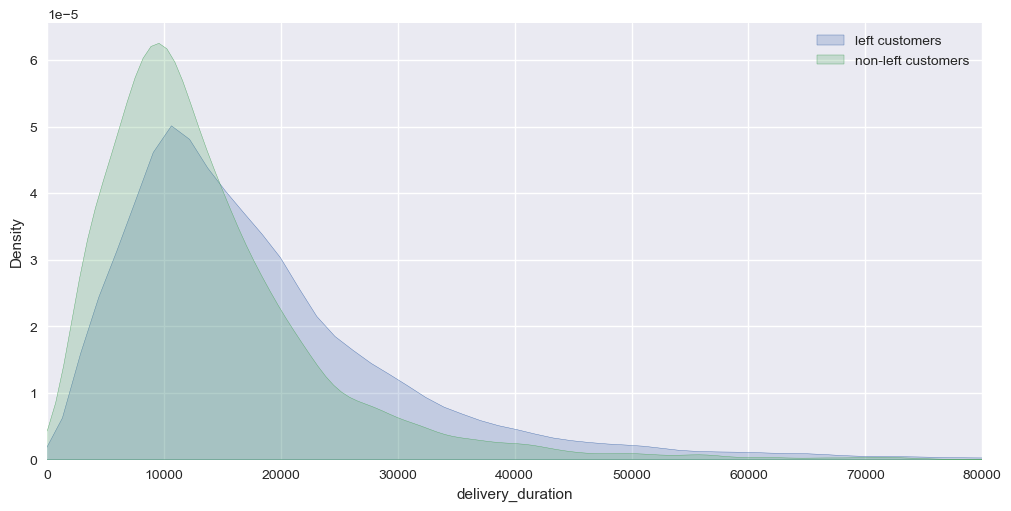

In [46]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
sns.kdeplot(x='delivery_duration', data=df_churn,fill=True, ax=ax, label='left customers')
sns.kdeplot(x='delivery_duration', data=df_churn_complement,fill=True, ax=ax, label='non-left customers')

ax.legend()
ax.set_xlim(0,80000)

plt.show()

# churn vs churn_complement

## category

In [47]:
df_churn.info()

<class 'pandas.core.frame.DataFrame'>
Index: 107841 entries, 0 to 76635
Data columns (total 27 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    107841 non-null  object        
 1   customer_unique_id             107841 non-null  object        
 2   customer_zip_code_prefix       107841 non-null  int64         
 3   order_id                       107841 non-null  object        
 4   order_status                   107841 non-null  object        
 5   order_purchase_timestamp       107841 non-null  datetime64[ns]
 6   order_approved_at              107754 non-null  datetime64[ns]
 7   order_delivered_customer_date  104734 non-null  datetime64[ns]
 8   order_estimated_delivery_date  107841 non-null  object        
 9   total_orders                   107841 non-null  int64         
 10  product_id                     107144 non-null  object        
 11  seller

In [48]:
df_churn_complement.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9725 entries, 5 to 118387
Data columns (total 27 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   customer_id                    9725 non-null   object        
 1   customer_unique_id             9725 non-null   object        
 2   customer_zip_code_prefix       9725 non-null   int64         
 3   order_id                       9725 non-null   object        
 4   order_status                   9725 non-null   object        
 5   order_purchase_timestamp       9725 non-null   datetime64[ns]
 6   order_approved_at              9646 non-null   datetime64[ns]
 7   order_delivered_customer_date  9477 non-null   datetime64[ns]
 8   order_estimated_delivery_date  9725 non-null   object        
 9   total_orders                   9725 non-null   int64         
 10  product_id                     9611 non-null   object        
 11  seller_id           

In [49]:
df_churn.groupby('product_category_name_english').size().sort_values(ascending=False).head(10)

product_category_name_english
bed_bath_table           10529
health_beauty             9033
sports_leisure            8072
furniture_decor           7878
computers_accessories     7425
housewares                6567
watches_gifts             5676
telephony                 4404
garden_tools              4236
auto                      4004
dtype: int64

In [50]:
df_churn_complement.groupby('product_category_name_english').size().sort_values(ascending=False).head(10)

product_category_name_english
bed_bath_table           1146
health_beauty             870
sports_leisure            789
furniture_decor           764
housewares                754
computers_accessories     580
watches_gifts             506
auto                      358
garden_tools              322
telephony                 305
dtype: int64

## zip-code

In [51]:
df_churn.groupby('customer_zip_code_prefix').size().sort_values(ascending=False).head(10)

customer_zip_code_prefix
22790    140
22793    139
24220    131
24230    127
22775    118
35162    117
29101    113
11740    105
35500     99
37200     99
dtype: int64

In [52]:
df_churn_complement.groupby('customer_zip_code_prefix').size().sort_values(ascending=False).head(10)

customer_zip_code_prefix
3227     79
7131     35
13087    28
24220    27
4140     24
12243    22
24240    21
84600    20
98005    20
13215    19
dtype: int64

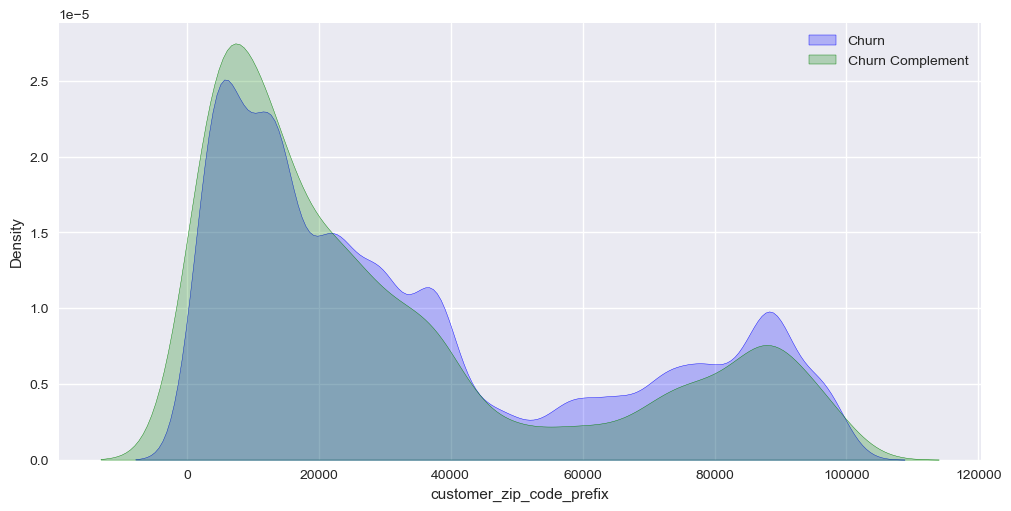

In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# 각 데이터셋에 대한 kdeplot을 그립니다. 각각에 대해 label을 지정하여 범례에 나타나게 합니다.
sns.kdeplot(x='customer_zip_code_prefix', data=df_churn, fill=True, ax=ax, label='Churn', color='blue')
sns.kdeplot(x='customer_zip_code_prefix', data=df_churn_complement, fill=True, ax=ax, label='Churn Complement', color='green')

# 범례 표시
plt.legend()

plt.show()

## 지불방식 관찰

<Axes: xlabel='payment_type', ylabel='count'>

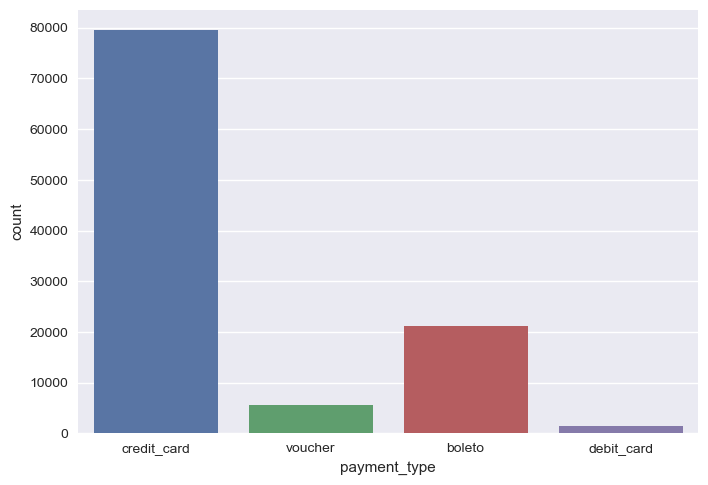

In [54]:
sns.countplot(x=df_churn['payment_type'])

<Axes: xlabel='payment_type', ylabel='count'>

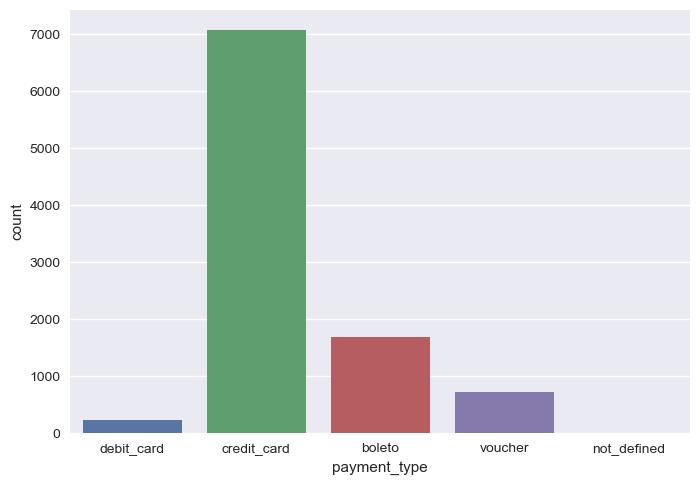

In [55]:
sns.countplot(x=df_churn_complement['payment_type'])

## 첫 구매 시기 관찰

In [56]:
#구매 시각을 정렬, unique id

df_churn=df_churn.sort_values(by='order_purchase_timestamp')
df_ndays=df_ndays.sort_values(by='order_purchase_timestamp')

In [57]:
#unique_id 별로 가장 빠른 주문 시각만 남기기

df_churn_first = df_churn.drop_duplicates(subset='customer_unique_id', keep='first')
df_ndays_first = df_ndays.drop_duplicates(subset='customer_unique_id', keep='first')

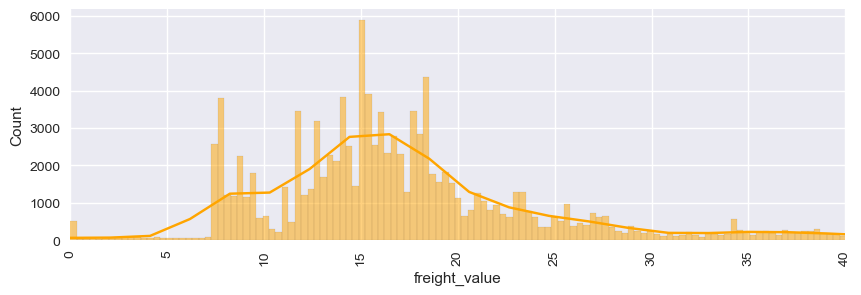

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

plt.figure(figsize=(10, 3))

# 첫 번째 subplot에 대한 설정
sns.histplot(df['freight_value'], kde=True, color='orange')
plt.xticks(rotation=90)
plt.xlim(0,40)

plt.show()


In [59]:
df.head(5)

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_sequential,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,1.0,credit_card,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,1.0,credit_card,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,1.0,credit_card,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,1.0,credit_card,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,1.0,credit_card,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort


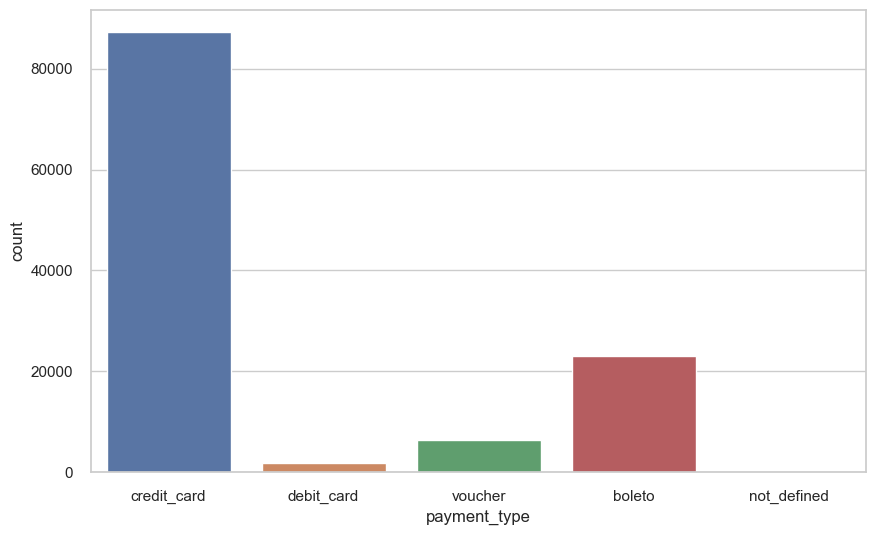

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 한글 폰트 설정
plt.rcParams['font.family'] = '맑은 고딕'  # 나눔고딕 폰트를 사용합니다.
plt.rcParams['font.size'] = 12  # 폰트 크기를 설정합니다.

# 가정: 'df'가 결제 정보를 포함한 DataFrame이라고 가정합니다.
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# 바플롯 생성
ax = sns.countplot(data=df, x='payment_type')

plt.show()


Text(0.5, 1.0, 'Order Status')

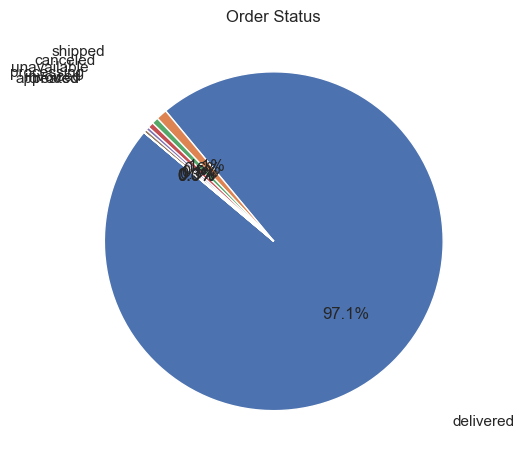

In [61]:
order_status_counts = df['order_status'].value_counts()
plt.pie(order_status_counts, labels=order_status_counts.index, 
        autopct='%1.1f%%', startangle=140, labeldistance=1.5)
plt.title("Order Status")

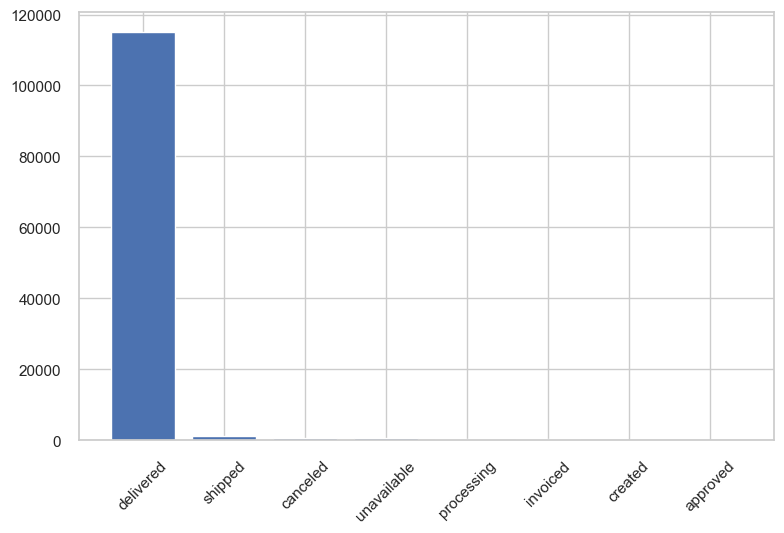

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

# 가정: df는 주문 상태를 나타내는 DataFrame이라고 가정합니다.
order_status_counts = df['order_status'].value_counts()

plt.bar(order_status_counts.index, order_status_counts)
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()


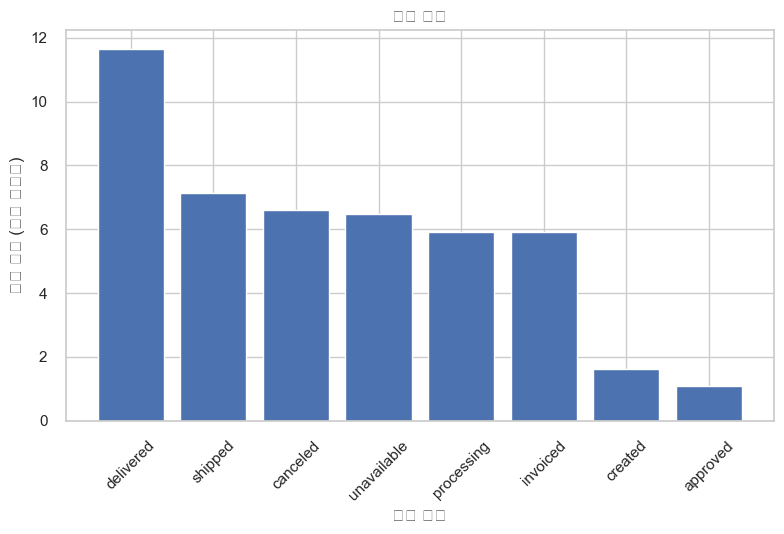

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 가정: df는 주문 상태를 나타내는 DataFrame이라고 가정합니다.
order_status_counts = df['order_status'].value_counts()

plt.bar(order_status_counts.index, np.log(order_status_counts))  # 로그 스케일 적용
plt.title("주문 상태")
plt.xlabel("주문 상태")
plt.ylabel("주문 횟수 (로그 스케일)")
plt.xticks(rotation=45)  # x축 라벨 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()


(0.0, 400.0)

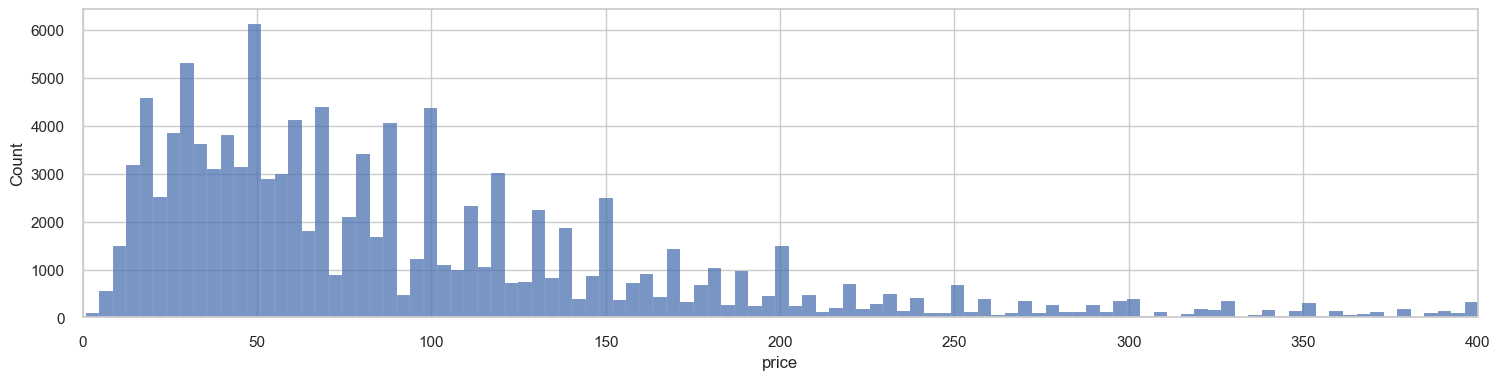

In [64]:
plt.figure(figsize=(18,4))
sns.histplot(data=df,x='price')
plt.xlim(0, 400)

Text(0.5, 1.0, 'category')

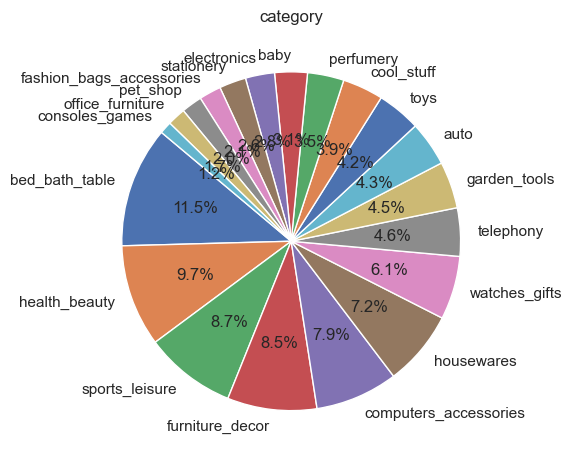

In [65]:
category_counts = df['product_category_name_english'].value_counts().head(20)
plt.pie(category_counts, labels=category_counts.index, 
        autopct='%1.1f%%', startangle=140)
plt.title("category")

# 주소와 구매품목의 관계 검정

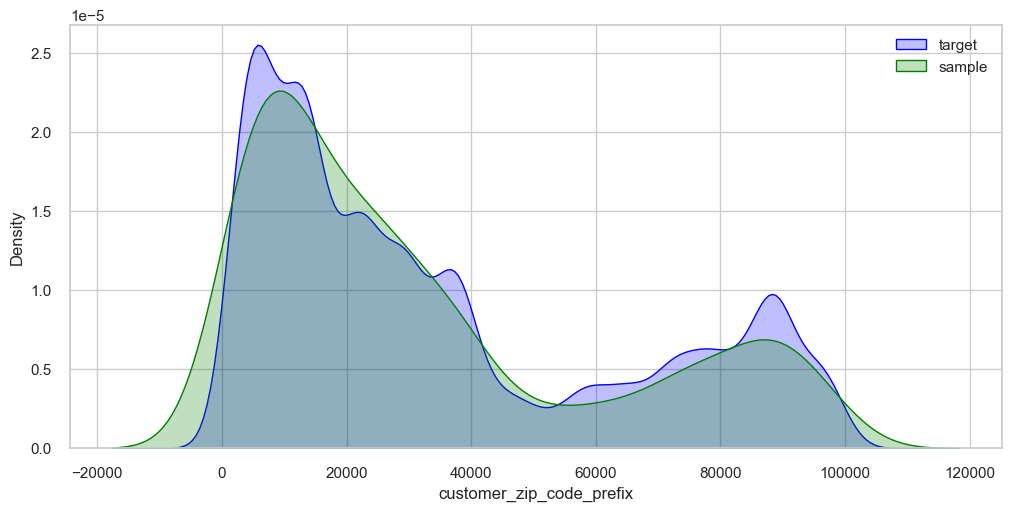

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(figsize=(10, 5), constrained_layout=True)

# 각 데이터셋에 대한 kdeplot을 그립니다. 각각에 대해 label을 지정하여 범례에 나타나게 합니다.
sns.kdeplot(x='customer_zip_code_prefix', data=df_1day, fill=True, ax=ax, label='target', color='blue')
sns.kdeplot(x='customer_zip_code_prefix', data=df_ndays, fill=True, ax=ax, label='sample', color='green')

# 범례 표시
plt.legend()

plt.show()


In [67]:
df_copy = df.copy()

In [68]:
df_ndays['is_between_10000_30000'] = np.where((df_ndays['customer_zip_code_prefix'] >= 10000) & (df_ndays['customer_zip_code_prefix'] <= 30000), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_10000_30000
22679,c24fc5f9a446b4d8262041b9c64de772,f7b981e8a280e455ac3cbe0d5d171bd1,80030,ec7a019261fce44180373d45b442d78f,delivered,2022-01-05 11:56:06,2022-01-05 12:10:17,2022-01-11 13:14:05,2022-02-01 00:00:00,2,...,1.0,19.62,fashion_bags_accessories,200.0,16.0,2.0,11.0,fashion_bags_accessories,1838.0,0
46032,e7659c6f9fc78ba546ee2b0615258589,a5d3bfee5b23b430b95c4ae295e1028a,13844,51ceba3ba51d4b4543e7f78e181e0ba9,delivered,2022-01-23 13:31:26,2022-01-23 13:45:18,2022-01-30 15:12:57,2022-02-28 00:00:00,2,...,1.0,104.30,furniture_decor,300.0,16.0,5.0,11.0,furniture_decor,2.0,1
38139,40e86a3dad650ba87f73f66396ca34ef,325e19085f3017b73be3d9fd98a93301,32400,adbbe31eab3ec8799e71b8fd89956464,delivered,2022-01-31 12:01:46,2022-02-01 02:50:26,2022-02-09 11:05:05,2022-03-13 00:00:00,2,...,1.0,65.05,furniture_decor,3000.0,69.0,11.0,11.0,furniture_decor,11.0,0
67781,f783bb6d6728b05cb674fc6709a56302,a7bbfaf8a288c45dc38d4693535dd63f,14057,ea8dfcfa112dd9df068022a643e58a22,delivered,2022-02-07 19:06:47,2022-02-09 02:50:10,2022-02-17 16:52:43,2022-03-20 00:00:00,2,...,1.0,44.42,fashion_bags_accessories,150.0,16.0,9.0,11.0,fashion_bags_accessories,9.0,1
10886,4922363693e673167789c03faf24a66d,c76762dfb642ac154475239639f7f8f4,20541,b3e176098b9f9f6122d37fa3cb06279b,delivered,2022-02-08 23:08:53,2022-02-08 23:23:27,2022-02-14 15:12:22,2022-03-09 00:00:00,3,...,1.0,66.65,bed_bath_table,2700.0,40.0,15.0,40.0,bed_bath_table,8.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,7a8a02e54cf3472df427e927f8b9c046,9c3af16efacb7aa06aa3bc674556c5d6,30170,5aac76cf7b07dd06fa4d50bf461d2f40,canceled,2023-09-25 11:59:18,NaN,NaN,2023-10-11 00:00:00,2,...,1.0,221.54,NaN,NaN,NaN,NaN,NaN,NaN,53.0,0
90381,55c9dad94ec1a2ba57998bdb376c230a,ba84da8c159659f116329563a0a981dd,25635,869997fbe01f39d184956b5c6bccfdbe,canceled,2023-09-26 08:40:15,NaN,NaN,2023-10-25 00:00:00,3,...,1.0,94.63,NaN,NaN,NaN,NaN,NaN,NaN,22.0,1
90495,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,616fa7d4871b87832197b2a137a115d2,canceled,2023-10-01 15:30:09,NaN,NaN,2023-10-23 00:00:00,2,...,1.0,80.38,NaN,NaN,NaN,NaN,NaN,NaN,46.0,1
81335,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2023-10-03 18:55:29,NaN,NaN,2023-10-16 00:00:00,3,...,1.0,197.55,NaN,NaN,NaN,NaN,NaN,NaN,30.0,1


In [71]:
df_ndays['did_buy_sports_leisure'] = np.where((df_ndays['product_category_name_english']=='sports_leisure'), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,duration_days,is_between_10000_30000,does_buy_health_beauty,did_buy_sports_leisure
22679,c24fc5f9a446b4d8262041b9c64de772,f7b981e8a280e455ac3cbe0d5d171bd1,80030,ec7a019261fce44180373d45b442d78f,delivered,2022-01-05 11:56:06,2022-01-05 12:10:17,2022-01-11 13:14:05,2022-02-01 00:00:00,2,...,fashion_bags_accessories,200.0,16.0,2.0,11.0,fashion_bags_accessories,1838.0,0,0,0
46032,e7659c6f9fc78ba546ee2b0615258589,a5d3bfee5b23b430b95c4ae295e1028a,13844,51ceba3ba51d4b4543e7f78e181e0ba9,delivered,2022-01-23 13:31:26,2022-01-23 13:45:18,2022-01-30 15:12:57,2022-02-28 00:00:00,2,...,furniture_decor,300.0,16.0,5.0,11.0,furniture_decor,2.0,1,0,0
38139,40e86a3dad650ba87f73f66396ca34ef,325e19085f3017b73be3d9fd98a93301,32400,adbbe31eab3ec8799e71b8fd89956464,delivered,2022-01-31 12:01:46,2022-02-01 02:50:26,2022-02-09 11:05:05,2022-03-13 00:00:00,2,...,furniture_decor,3000.0,69.0,11.0,11.0,furniture_decor,11.0,0,0,0
67781,f783bb6d6728b05cb674fc6709a56302,a7bbfaf8a288c45dc38d4693535dd63f,14057,ea8dfcfa112dd9df068022a643e58a22,delivered,2022-02-07 19:06:47,2022-02-09 02:50:10,2022-02-17 16:52:43,2022-03-20 00:00:00,2,...,fashion_bags_accessories,150.0,16.0,9.0,11.0,fashion_bags_accessories,9.0,1,0,0
10886,4922363693e673167789c03faf24a66d,c76762dfb642ac154475239639f7f8f4,20541,b3e176098b9f9f6122d37fa3cb06279b,delivered,2022-02-08 23:08:53,2022-02-08 23:23:27,2022-02-14 15:12:22,2022-03-09 00:00:00,3,...,bed_bath_table,2700.0,40.0,15.0,40.0,bed_bath_table,8.0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,7a8a02e54cf3472df427e927f8b9c046,9c3af16efacb7aa06aa3bc674556c5d6,30170,5aac76cf7b07dd06fa4d50bf461d2f40,canceled,2023-09-25 11:59:18,NaN,NaN,2023-10-11 00:00:00,2,...,NaN,NaN,NaN,NaN,NaN,NaN,53.0,0,0,0
90381,55c9dad94ec1a2ba57998bdb376c230a,ba84da8c159659f116329563a0a981dd,25635,869997fbe01f39d184956b5c6bccfdbe,canceled,2023-09-26 08:40:15,NaN,NaN,2023-10-25 00:00:00,3,...,NaN,NaN,NaN,NaN,NaN,NaN,22.0,1,0,0
90495,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,616fa7d4871b87832197b2a137a115d2,canceled,2023-10-01 15:30:09,NaN,NaN,2023-10-23 00:00:00,2,...,NaN,NaN,NaN,NaN,NaN,NaN,46.0,1,0,0
81335,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2023-10-03 18:55:29,NaN,NaN,2023-10-16 00:00:00,3,...,NaN,NaN,NaN,NaN,NaN,NaN,30.0,1,0,0


In [72]:
# 우선 교차표를 작성
table = pd.crosstab(df_ndays['is_between_10000_30000'], df_ndays['did_buy_sports_leisure'])
table

did_buy_sports_leisure,0,1
is_between_10000_30000,,
0,1377,163
1,742,64


In [73]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=3.934826895676637, pvalue=0.04729600789403512, dof=1, expected_freq=array([[1390.98891731,  149.01108269],
       [ 728.01108269,   77.98891731]]))

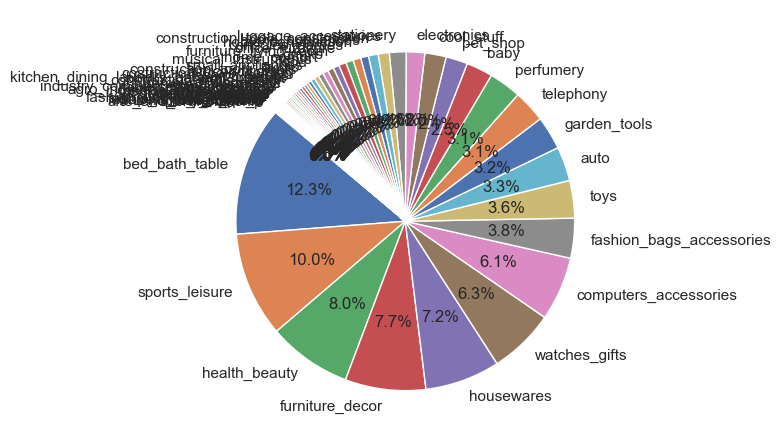

In [74]:
category_ratio= df_ndays['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

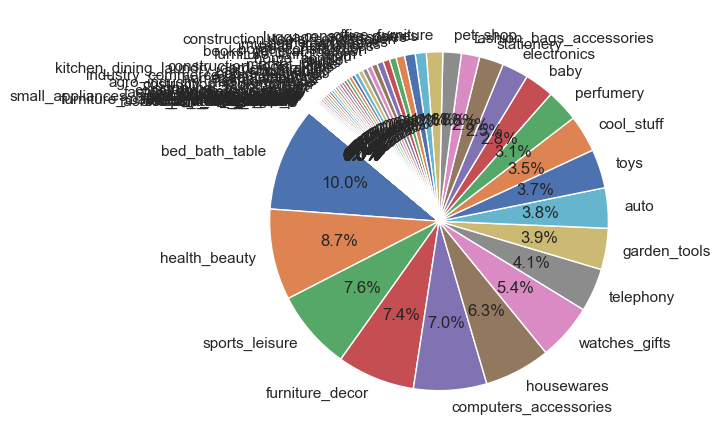

In [75]:
category_ratio= df_1day['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

# 구매 요일과 반복 구매 여부 관계 검정

In [76]:
df_1day['order_purchase_timestamp'] = pd.to_datetime(df_1day['order_purchase_timestamp'])
df_1day['day_of_week'] = df_1day['order_purchase_timestamp'].dt.dayofweek

In [77]:
df_ndays['order_purchase_timestamp'] = pd.to_datetime(df_ndays['order_purchase_timestamp'])
df_ndays['day_of_week'] = df_ndays['order_purchase_timestamp'].dt.dayofweek

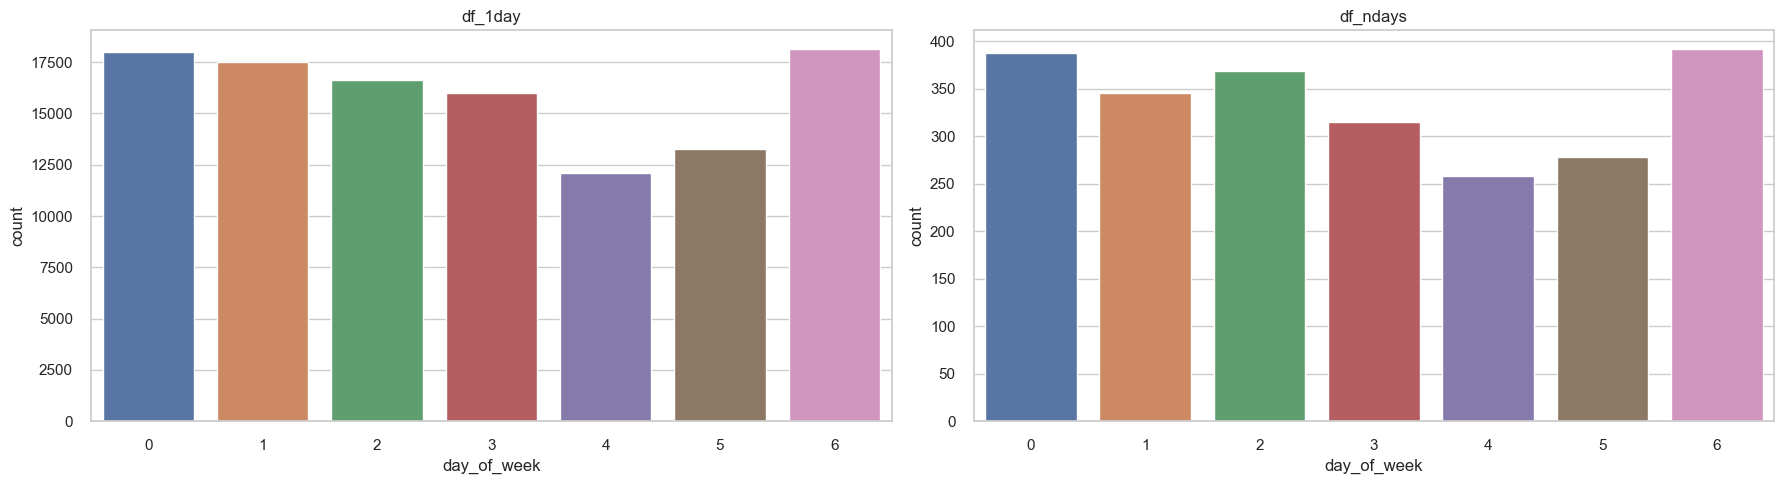

In [78]:
# 2개의 서브플롯을 만들기 위한 준비
fig, axes = plt.subplots(1, 2, figsize=(18, 5)) # 1행 2열의 서브플롯 구성

# 첫 번째 서브플롯에 category에 대한 countplot 그리기
sns.countplot(x='day_of_week', data=df_1day, ax=axes[0])
axes[0].set_title('df_1day')

# 두 번째 서브플롯에 region에 대한 countplot 그리기
sns.countplot(x='day_of_week', data=df_ndays, ax=axes[1])
axes[1].set_title('df_ndays')

plt.tight_layout() # 서브플롯들 사이에 적절한 간격 유지
plt.show()

In [81]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['day_of_week'] = df['order_purchase_timestamp'].dt.dayofweek

In [82]:
df_copy = df.copy()
df_copy

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_type,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,credit_card,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,credit_card,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares,3
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,credit_card,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture,4
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,credit_card,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,credit_card,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,6760e20addcf0121e9d58f2f1ff14298,delivered,2023-04-07 15:48:17,2023-04-07 16:08:45,2023-04-13 20:06:37,2023-04-25 00:00:00,1,...,credit_card,6.0,88.78,books_general_interest,611.0,22.0,22.0,23.0,books_general_interest,4
118430,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2023-04-04 08:20:22,2023-04-04 08:35:12,2023-04-11 18:54:45,2023-04-20 00:00:00,1,...,credit_card,3.0,129.06,sports_leisure,1211.0,25.0,24.0,22.0,sports_leisure,1
118431,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fed4434add09a6f332ea398efd656a5c,delivered,2023-04-08 20:11:50,2023-04-08 20:30:03,2023-05-09 19:03:15,2023-05-02 00:00:00,1,...,credit_card,5.0,56.04,health_beauty,870.0,25.0,20.0,18.0,health_beauty,5
118432,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,e31ec91cea1ecf97797787471f98a8c2,delivered,2022-11-03 21:08:33,2022-11-03 21:31:20,2022-11-16 19:58:39,2022-12-05 00:00:00,1,...,credit_card,2.0,711.07,watches_gifts,710.0,19.0,13.0,14.0,watches_gifts,3


In [83]:
df_copy['is_wed'] = np.where((df_copy['day_of_week']==2), 1, 0)
df_copy.head(20)

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_wed
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,2.0,146.87,office_furniture,8683.0,54.0,64.0,31.0,office_furniture,0,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,8.0,335.48,housewares,10150.0,89.0,15.0,40.0,housewares,3,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,7.0,157.73,office_furniture,8267.0,52.0,52.0,17.0,office_furniture,4,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,1.0,173.30,office_furniture,12160.0,56.0,51.0,28.0,office_furniture,0,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,8.0,252.25,home_confort,5200.0,45.0,15.0,35.0,home_confort,5,0
5,879864dab9bc3047522c92c82e1212b8,4c93744516667ad3b8f1fb645a3116a4,89254,5741ea1f91b5fbab2bd2dc653a5b5099,delivered,2022-09-14 18:14:31,2022-09-14 18:25:11,2022-09-28 17:32:43,2022-10-04 00:00:00,2,...,1.0,282.21,sports_leisure,4450.0,60.0,15.0,15.0,sports_leisure,2,1
6,fd826e7cf63160e536e0908c76c3f441,addec96d2e059c80c30fe6871d30d177,4534,36e694cf4cbc2a4803200c35e84abdc4,delivered,2023-02-19 14:38:35,2023-02-19 14:50:37,2023-02-20 16:25:51,2023-03-05 00:00:00,1,...,1.0,22.77,computers_accessories,100.0,16.0,3.0,13.0,computers_accessories,6,0
7,5e274e7a0c3809e14aba7ad5aae0d407,57b2a98a409812fe9618067b6b8ebe4f,35182,1093c8304c7a003280dd34598194913d,delivered,2022-11-16 19:29:02,2022-11-16 19:55:41,2022-11-27 12:44:36,2022-12-08 00:00:00,1,...,3.0,36.01,NaN,250.0,15.0,8.0,20.0,NaN,2,1
8,5adf08e34b2e993982a47070956c5c65,1175e95fb47ddff9de6b2b06188f7e0d,81560,1ebeea841c590e86a14a0d7a48e7d062,delivered,2023-01-18 12:35:44,2023-01-18 12:56:32,2023-01-26 15:17:57,2023-02-20 00:00:00,2,...,1.0,39.10,toys,350.0,28.0,10.0,12.0,toys,2,1
9,4b7139f34592b3a31687243a302fa75b,9afe194fb833f79e300e37e580171f22,30575,7433cbcc783205509d66a5260da5b574,delivered,2023-01-08 11:22:34,2023-01-08 11:35:27,2023-01-13 14:51:55,2023-02-05 00:00:00,1,...,1.0,122.47,furniture_decor,2500.0,40.0,10.0,30.0,furniture_decor,6,0


In [85]:
# df_ndays의 'customer_unique_id' 열의 고유 값들을 리스트로 추출
df_ndays_ids = df_ndays['customer_unique_id'].unique().tolist()

# df_copy의 'is_sample' 열을 생성, df_copy의 'customer_unique_id' 값이 df_ndays_ids 리스트에 있는지 여부에 따라 1 또는 0 할당
df_copy['is_sample'] = df_copy['customer_unique_id'].apply(lambda x: 1 if x in df_ndays_ids else 0)


In [86]:
# 우선 교차표를 작성
table = pd.crosstab(df_copy['is_sample'], df_copy['is_wed'])
table

is_wed,0,1
is_sample,,
0,95781,16746
1,4928,979


In [87]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=12.489788595822326, pvalue=0.00040918249559097463, dof=1, expected_freq=array([[95686.0499772, 16840.9500228],
       [ 5022.9500228,   884.0499772]]))

## 수요일 구매와 구매 품목 관계 검정

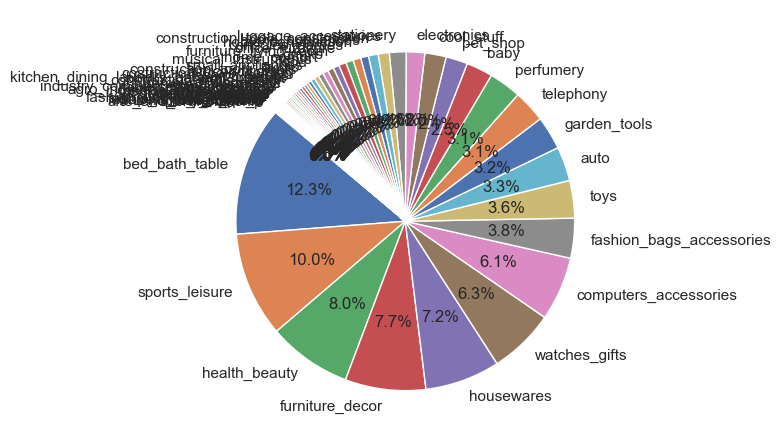

In [88]:
category_ratio= df_ndays['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [92]:
df_ndays['is_wed'] = np.where((df_ndays['day_of_week']==2), 1, 0)
df_wed = df_ndays[df_ndays['is_wed']==1]
df_wed.columns

Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'order_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_customer_date',
       'order_estimated_delivery_date', 'total_orders', 'product_id',
       'seller_id', 'price', 'freight_value', 'total_order_items',
       'payment_sequential', 'payment_type', 'payment_installments',
       'payment_value', 'product_category_name', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'product_category_name_english', 'duration_days',
       'is_between_10000_30000', 'does_buy_health_beauty',
       'did_buy_sports_leisure', 'day_of_week', 'is_wed'],
      dtype='object')

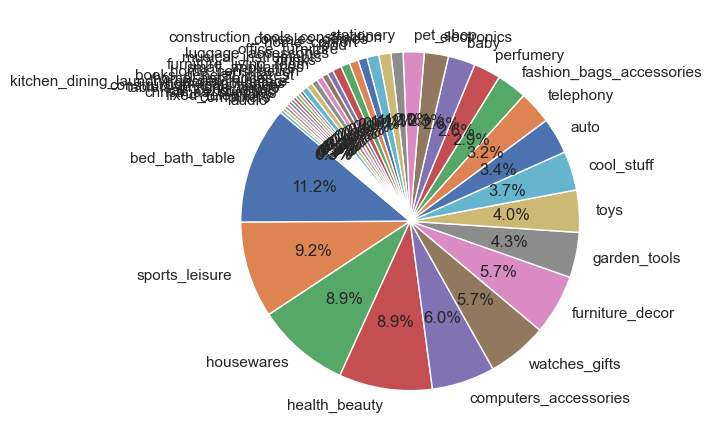

In [93]:
category_ratio= df_wed['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [94]:
df_ndays['did_buy_cool'] = np.where((df_ndays['product_category_name_english']=='cool_stuff'),1,0)

In [95]:
# 우선 교차표를 작성
table = pd.crosstab(df_ndays['did_buy_cool'],df_ndays['is_wed'])
table

is_wed,0,1
did_buy_cool,,
0,1944,356
1,33,13


In [96]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=4.6367485843295455, pvalue=0.031294238998183885, dof=1, expected_freq=array([[1938.23529412,  361.76470588],
       [  38.76470588,    7.23529412]]))

# 구매 시간대와 재구매 여부 관계 검정

In [97]:
df_ndays['time_zone'] = df_ndays['order_purchase_timestamp'].dt.time
df_1day['time_zone'] = df_1day['order_purchase_timestamp'].dt.time
df_copy['time_zone'] = df_copy['order_purchase_timestamp'].dt.time

<Axes: xlabel='time_numeric', ylabel='Density'>

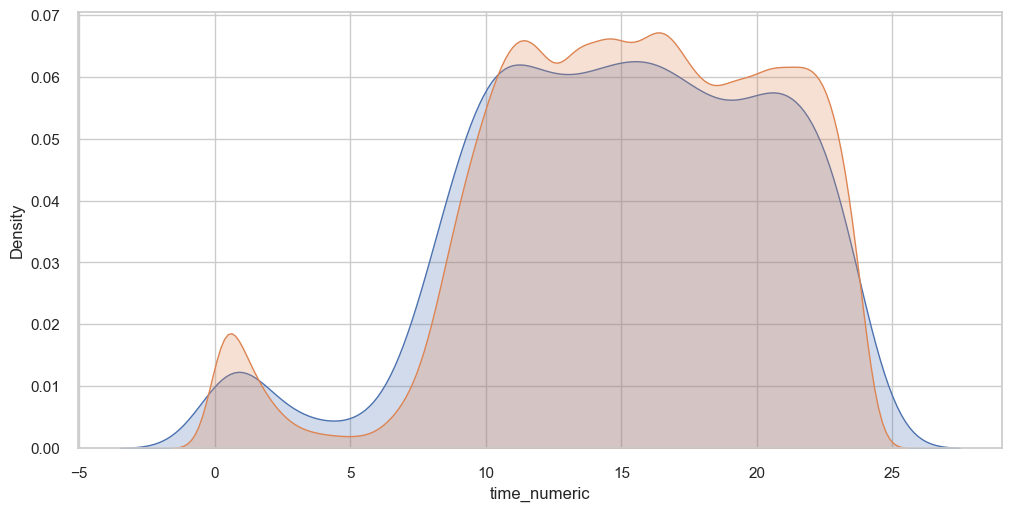

In [98]:
fig, ax = plt.subplots(figsize=(10,5),constrained_layout=True)
# 'time_zone' 열을 시간 단위의 소수로 변환하는 예
df_ndays['time_numeric'] = df_ndays['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df_1day['time_numeric'] = df_1day['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df_copy['time_numeric'] = df_copy['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)

# 이제 'time_numeric' 열을 사용하여 sns.kdeplot을 그립니다.
sns.kdeplot(x='time_numeric', data=df_ndays, fill=True, ax=ax)
sns.kdeplot(x='time_numeric', data=df_1day, fill=True, ax=ax)

In [99]:
df_ndays['is_between_2_10'] = np.where((df_ndays['time_numeric'] >= 2) & (df_ndays['time_numeric'] <= 10), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,duration_days,is_between_10000_30000,does_buy_health_beauty,did_buy_sports_leisure,day_of_week,is_wed,did_buy_cool,time_zone,time_numeric,is_between_2_10
22679,c24fc5f9a446b4d8262041b9c64de772,f7b981e8a280e455ac3cbe0d5d171bd1,80030,ec7a019261fce44180373d45b442d78f,delivered,2022-01-05 11:56:06,2022-01-05 12:10:17,2022-01-11 13:14:05,2022-02-01 00:00:00,2,...,1838.0,0,0,0,2,1,0,11:56:06,11.935000,0
46032,e7659c6f9fc78ba546ee2b0615258589,a5d3bfee5b23b430b95c4ae295e1028a,13844,51ceba3ba51d4b4543e7f78e181e0ba9,delivered,2022-01-23 13:31:26,2022-01-23 13:45:18,2022-01-30 15:12:57,2022-02-28 00:00:00,2,...,2.0,1,0,0,6,0,0,13:31:26,13.523889,0
38139,40e86a3dad650ba87f73f66396ca34ef,325e19085f3017b73be3d9fd98a93301,32400,adbbe31eab3ec8799e71b8fd89956464,delivered,2022-01-31 12:01:46,2022-02-01 02:50:26,2022-02-09 11:05:05,2022-03-13 00:00:00,2,...,11.0,0,0,0,0,0,0,12:01:46,12.029444,0
67781,f783bb6d6728b05cb674fc6709a56302,a7bbfaf8a288c45dc38d4693535dd63f,14057,ea8dfcfa112dd9df068022a643e58a22,delivered,2022-02-07 19:06:47,2022-02-09 02:50:10,2022-02-17 16:52:43,2022-03-20 00:00:00,2,...,9.0,1,0,0,0,0,0,19:06:47,19.113056,0
10886,4922363693e673167789c03faf24a66d,c76762dfb642ac154475239639f7f8f4,20541,b3e176098b9f9f6122d37fa3cb06279b,delivered,2022-02-08 23:08:53,2022-02-08 23:23:27,2022-02-14 15:12:22,2022-03-09 00:00:00,3,...,8.0,1,0,0,1,0,0,23:08:53,23.148056,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,7a8a02e54cf3472df427e927f8b9c046,9c3af16efacb7aa06aa3bc674556c5d6,30170,5aac76cf7b07dd06fa4d50bf461d2f40,canceled,2023-09-25 11:59:18,NaN,NaN,2023-10-11 00:00:00,2,...,53.0,0,0,0,0,0,0,11:59:18,11.988333,0
90381,55c9dad94ec1a2ba57998bdb376c230a,ba84da8c159659f116329563a0a981dd,25635,869997fbe01f39d184956b5c6bccfdbe,canceled,2023-09-26 08:40:15,NaN,NaN,2023-10-25 00:00:00,3,...,22.0,1,0,0,1,0,0,08:40:15,8.670833,1
90495,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,616fa7d4871b87832197b2a137a115d2,canceled,2023-10-01 15:30:09,NaN,NaN,2023-10-23 00:00:00,2,...,46.0,1,0,0,6,0,0,15:30:09,15.502500,0
81335,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2023-10-03 18:55:29,NaN,NaN,2023-10-16 00:00:00,3,...,30.0,1,0,0,1,0,0,18:55:29,18.924722,0


In [100]:
df_2_10 = df_ndays[df_ndays['is_between_2_10']==1]

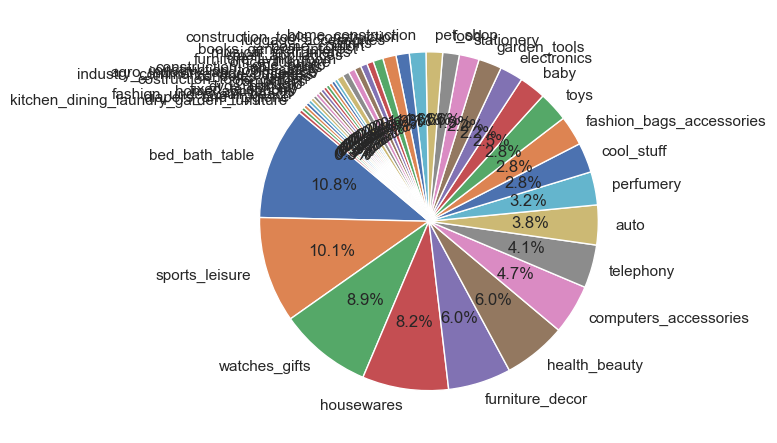

In [101]:
category_ratio= df_2_10['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

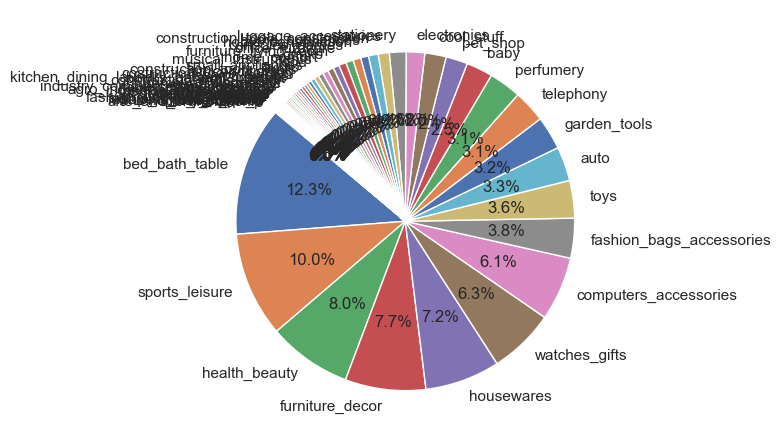

In [102]:
category_ratio= df_ndays['product_category_name_english'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

## 구매 시간대와 결제 방식 관계 검정

In [104]:
df_copy['does_buy_sports_leisure'] = np.where((df_copy['product_category_name_english']=='sports_leisure'), 1, 0)
df_copy

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,day_of_week,is_wed,is_sample,time_zone,time_numeric,does_buy_sports_leisure
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,00e7ee1b050b8499577073aeb2a297a1,delivered,2022-05-16 15:05:35,2022-05-16 15:22:12,2022-05-25 10:35:35,2022-06-05 00:00:00,1,...,54.0,64.0,31.0,office_furniture,0,0,0,15:05:35,15.093056,0
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,29150127e6685892b6eab3eec79f59c7,delivered,2023-01-12 20:48:24,2023-01-12 20:58:32,2023-01-29 12:41:19,2023-02-06 00:00:00,1,...,89.0,15.0,40.0,housewares,3,0,0,20:48:24,20.806667,0
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,b2059ed67ce144a36e2aa97d2c9e9ad2,delivered,2023-05-19 16:07:45,2023-05-20 16:19:10,2023-06-14 17:58:51,2023-06-13 00:00:00,1,...,52.0,52.0,17.0,office_furniture,4,0,0,16:07:45,16.129167,0
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,951670f92359f4fe4a63112aa7306eba,delivered,2023-03-13 16:06:38,2023-03-13 17:29:19,2023-03-28 16:04:25,2023-04-10 00:00:00,1,...,56.0,51.0,28.0,office_furniture,0,0,0,16:06:38,16.110556,0
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,6b7d50bd145f6fc7f33cebabd7e49d0f,delivered,2023-07-29 09:51:30,2023-07-29 10:10:09,2023-08-09 20:55:48,2023-08-15 00:00:00,1,...,45.0,15.0,35.0,home_confort,5,0,0,09:51:30,9.858333,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118429,17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8,3937,6760e20addcf0121e9d58f2f1ff14298,delivered,2023-04-07 15:48:17,2023-04-07 16:08:45,2023-04-13 20:06:37,2023-04-25 00:00:00,1,...,22.0,22.0,23.0,books_general_interest,4,0,0,15:48:17,15.804722,0
118430,e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d,6764,9ec0c8947d973db4f4e8dcf1fbfa8f1b,delivered,2023-04-04 08:20:22,2023-04-04 08:35:12,2023-04-11 18:54:45,2023-04-20 00:00:00,1,...,25.0,24.0,22.0,sports_leisure,1,0,0,08:20:22,8.339444,1
118431,5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99,60115,fed4434add09a6f332ea398efd656a5c,delivered,2023-04-08 20:11:50,2023-04-08 20:30:03,2023-05-09 19:03:15,2023-05-02 00:00:00,1,...,25.0,20.0,18.0,health_beauty,5,0,0,20:11:50,20.197222,0
118432,56b18e2166679b8a959d72dd06da27f9,73c2643a0a458b49f58cea58833b192e,92120,e31ec91cea1ecf97797787471f98a8c2,delivered,2022-11-03 21:08:33,2022-11-03 21:31:20,2022-11-16 19:58:39,2022-12-05 00:00:00,1,...,19.0,13.0,14.0,watches_gifts,3,0,0,21:08:33,21.142500,0


In [105]:
df_2_10 = df_ndays[df_ndays['is_between_2_10']==1]

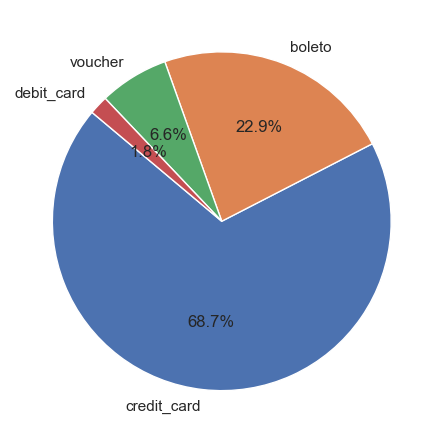

In [106]:
category_ratio= df_2_10['payment_type'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

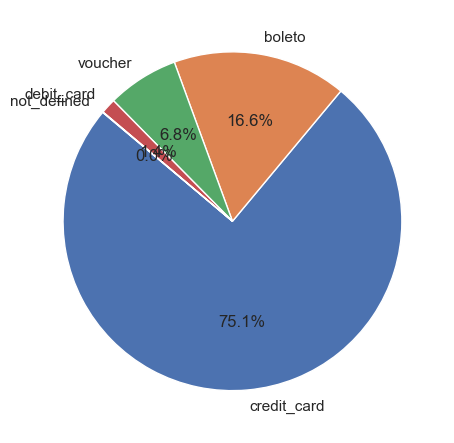

In [107]:
category_ratio= df_ndays['payment_type'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

In [108]:
df_ndays['is_boleto'] = np.where((df_ndays['payment_type']=='boleto'), 1, 0)
df_ndays

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,is_between_10000_30000,does_buy_health_beauty,did_buy_sports_leisure,day_of_week,is_wed,did_buy_cool,time_zone,time_numeric,is_between_2_10,is_boleto
22679,c24fc5f9a446b4d8262041b9c64de772,f7b981e8a280e455ac3cbe0d5d171bd1,80030,ec7a019261fce44180373d45b442d78f,delivered,2022-01-05 11:56:06,2022-01-05 12:10:17,2022-01-11 13:14:05,2022-02-01 00:00:00,2,...,0,0,0,2,1,0,11:56:06,11.935000,0,0
46032,e7659c6f9fc78ba546ee2b0615258589,a5d3bfee5b23b430b95c4ae295e1028a,13844,51ceba3ba51d4b4543e7f78e181e0ba9,delivered,2022-01-23 13:31:26,2022-01-23 13:45:18,2022-01-30 15:12:57,2022-02-28 00:00:00,2,...,1,0,0,6,0,0,13:31:26,13.523889,0,0
38139,40e86a3dad650ba87f73f66396ca34ef,325e19085f3017b73be3d9fd98a93301,32400,adbbe31eab3ec8799e71b8fd89956464,delivered,2022-01-31 12:01:46,2022-02-01 02:50:26,2022-02-09 11:05:05,2022-03-13 00:00:00,2,...,0,0,0,0,0,0,12:01:46,12.029444,0,1
67781,f783bb6d6728b05cb674fc6709a56302,a7bbfaf8a288c45dc38d4693535dd63f,14057,ea8dfcfa112dd9df068022a643e58a22,delivered,2022-02-07 19:06:47,2022-02-09 02:50:10,2022-02-17 16:52:43,2022-03-20 00:00:00,2,...,1,0,0,0,0,0,19:06:47,19.113056,0,1
10886,4922363693e673167789c03faf24a66d,c76762dfb642ac154475239639f7f8f4,20541,b3e176098b9f9f6122d37fa3cb06279b,delivered,2022-02-08 23:08:53,2022-02-08 23:23:27,2022-02-14 15:12:22,2022-03-09 00:00:00,3,...,1,0,0,1,0,0,23:08:53,23.148056,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39567,7a8a02e54cf3472df427e927f8b9c046,9c3af16efacb7aa06aa3bc674556c5d6,30170,5aac76cf7b07dd06fa4d50bf461d2f40,canceled,2023-09-25 11:59:18,NaN,NaN,2023-10-11 00:00:00,2,...,0,0,0,0,0,0,11:59:18,11.988333,0,0
90381,55c9dad94ec1a2ba57998bdb376c230a,ba84da8c159659f116329563a0a981dd,25635,869997fbe01f39d184956b5c6bccfdbe,canceled,2023-09-26 08:40:15,NaN,NaN,2023-10-25 00:00:00,3,...,1,0,0,1,0,0,08:40:15,8.670833,1,0
90495,bf6181a85bbb4115736c0a8db1a53be3,634420a0ea42302205032ed44ac7fccc,27175,616fa7d4871b87832197b2a137a115d2,canceled,2023-10-01 15:30:09,NaN,NaN,2023-10-23 00:00:00,2,...,1,0,0,6,0,0,15:30:09,15.502500,0,0
81335,4c2ec60c29d10c34bd49cb88aa85cfc4,af5454198a97379394cacf676e1e96cb,11900,a2ac6dad85cf8af5b0afb510a240fe8c,canceled,2023-10-03 18:55:29,NaN,NaN,2023-10-16 00:00:00,3,...,1,0,0,1,0,0,18:55:29,18.924722,0,0


In [109]:
# 우선 교차표를 작성
table = pd.crosstab(df_ndays['is_between_2_10'],df_ndays['is_boleto'])
table

is_boleto,0,1
is_between_2_10,,
0,1700,314
1,256,76


In [110]:
spst.chi2_contingency(table)

Chi2ContingencyResult(statistic=10.439872657863841, pvalue=0.0012332377235012824, dof=1, expected_freq=array([[1679.19181586,  334.80818414],
       [ 276.80818414,   55.19181586]]))

# 잠재고객 파악

## 잠재 고객의 구매 시간대 파악

In [111]:
df_poten['time_zone'] = df_poten['order_purchase_timestamp'].dt.time
df_poten['time_numeric'] = df_poten['time_zone'].apply(lambda x: x.hour + x.minute / 60 + x.second / 3600)
df_poten

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,payment_installments,payment_value,product_category_name,product_weight_g,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,time_zone,time_numeric
16,a7c125a0a07b75146167b7f04a7f8e98,5c2991dbd08bbf3cf410713c4de5a0b5,22750,72bab69c50432c6f94d8b50a5f84b69a,delivered,2023-08-13 23:45:05,2023-08-13 23:55:13,2023-08-17 20:03:08,2023-08-30 00:00:00,1,...,2.0,136.93,auto,1200.0,16.0,9.0,31.0,auto,23:45:05,23.751389
92,6c9a5923526346cbc0bd7bbd92269c01,cf6d4152d758efc43910e0141ae5b912,3733,580e2b6c3cb7687af1cb01ebeed86265,delivered,2023-08-22 11:39:32,2023-08-22 11:50:14,2023-08-23 18:34:25,2023-08-27 00:00:00,1,...,8.0,361.20,watches_gifts,250.0,16.0,16.0,16.0,watches_gifts,11:39:32,11.658889
93,1b2cb35b19b40b61f953d32ea157b337,468d559ef2dcd2bea6d8db78959fb90f,83709,fba547ee0dbc8830f00e8d3cc83bf246,delivered,2023-08-25 11:24:27,2023-08-25 11:35:18,2023-08-30 19:54:25,2023-09-19 00:00:00,1,...,1.0,39.15,computers_accessories,150.0,31.0,3.0,28.0,computers_accessories,11:24:27,11.407500
118,ad6891a1937cb8723a2c08ba1ae59873,9dbb05f5577e862337b93feb8f358839,65058,38289de96763d9d81470f67583f4b2f0,delivered,2023-08-22 11:49:11,2023-08-23 02:44:21,2023-08-29 19:48:37,2023-08-27 00:00:00,1,...,1.0,76.15,health_beauty,350.0,19.0,12.0,13.0,health_beauty,11:49:11,11.819722
169,2f97782bbc64b71cba9e79d12757479b,7aeb8dc11cd50c32f37fea0435c4e9b1,5874,ac1a1d01dcd4350d31887f6eab3f63d5,delivered,2023-08-23 21:43:41,2023-08-23 21:55:16,2023-08-30 21:05:56,2023-08-31 00:00:00,1,...,1.0,35.65,small_appliances_home_oven_and_coffee,150.0,27.0,13.0,17.0,small_appliances_home_oven_and_coffee,21:43:41,21.728056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80314,7fe022a904d647429c6e08a8f34c9b22,931a4a1a3e2cf8b4b4d33922f1469dbe,12243,1c3f752b9a4d09bf1e016439a427d5f8,delivered,2023-08-17 23:21:15,2023-08-17 23:35:14,2023-08-21 19:36:43,2023-08-23 00:00:00,2,...,1.0,23.88,arts_and_craftmanship,100.0,22.0,2.0,15.0,arts_and_craftmanship,23:21:15,23.354167
12873,dc6ab71bcbf17b38e8702924f379b68a,b5d391e8447d5ae0f8b852be83249e07,18120,ba75e370e47503142da34eea6301546a,delivered,2023-08-14 20:14:55,2023-08-14 20:25:26,2023-08-24 17:08:30,2023-08-30 00:00:00,2,...,8.0,379.32,construction_tools_lights,3750.0,50.0,50.0,50.0,construction_tools_lights,20:14:55,20.248611
65270,939b596a4a7229ebad09bcbad40538e6,b948343ff2e4e183e27e22ca63968d2b,5848,f22994b30f7ab7b86eacb2ea99e61a86,delivered,2023-08-16 10:30:31,2023-08-18 02:35:17,2023-08-21 17:27:56,2023-08-21 00:00:00,2,...,1.0,88.62,sports_leisure,400.0,16.0,9.0,11.0,sports_leisure,10:30:31,10.508611
20994,c9b91aae07c6cd838cac23a7e534e1df,d649357bd5b1b116bf9662f41259db37,14300,3058f418c175f89b5dc680bcb5634ab1,delivered,2023-08-22 18:03:39,2023-08-22 18:15:39,2023-08-28 09:52:09,2023-09-14 00:00:00,2,...,4.0,92.03,fashion_bags_accessories,500.0,16.0,16.0,16.0,fashion_bags_accessories,18:03:39,18.060833


In [112]:
df_poten['is_between_2_10'] = np.where((df_poten['time_numeric'] >= 2) & (df_poten['time_numeric'] <= 10), 1, 0)

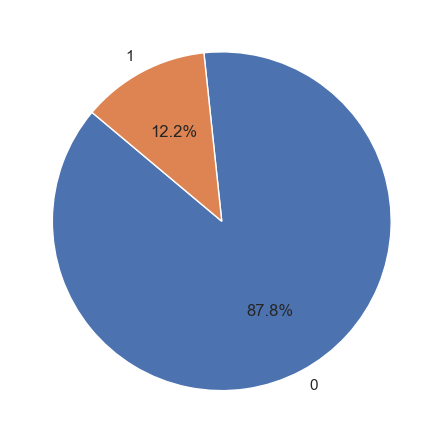

In [113]:
category_ratio= df_poten['is_between_2_10'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

## 잠재 고객의 구매 요일 파악

In [115]:
df_poten['order_purchase_timestamp'] = pd.to_datetime(df_poten['order_purchase_timestamp'])
df_poten['day_of_week'] = df_poten['order_purchase_timestamp'].dt.dayofweek

In [116]:
df_poten['is_wed'] = np.where((df_poten['day_of_week'] ==2 ), 1, 0)

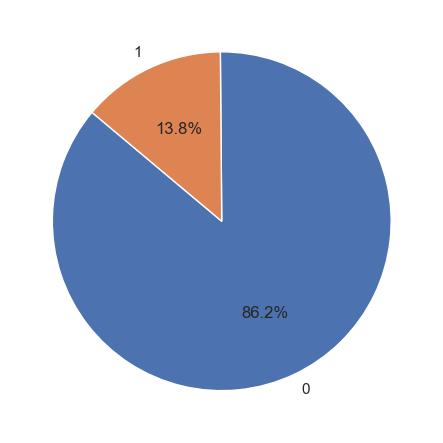

In [117]:
category_ratio= df_poten['is_wed'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

## 잠재 고객의 zip code 파악

In [118]:
df_poten['is_between_10000_30000'] = np.where((df_poten['customer_zip_code_prefix'] >= 10000) & (df_poten['customer_zip_code_prefix'] <= 30000), 1, 0)
df_poten

,customer_id,customer_unique_id,customer_zip_code_prefix,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,total_orders,...,product_length_cm,product_height_cm,product_width_cm,product_category_name_english,time_zone,time_numeric,is_between_2_10,day_of_week,is_wed,is_between_10000_30000
16,a7c125a0a07b75146167b7f04a7f8e98,5c2991dbd08bbf3cf410713c4de5a0b5,22750,72bab69c50432c6f94d8b50a5f84b69a,delivered,2023-08-13 23:45:05,2023-08-13 23:55:13,2023-08-17 20:03:08,2023-08-30 00:00:00,1,...,16.0,9.0,31.0,auto,23:45:05,23.751389,0,6,0,1
92,6c9a5923526346cbc0bd7bbd92269c01,cf6d4152d758efc43910e0141ae5b912,3733,580e2b6c3cb7687af1cb01ebeed86265,delivered,2023-08-22 11:39:32,2023-08-22 11:50:14,2023-08-23 18:34:25,2023-08-27 00:00:00,1,...,16.0,16.0,16.0,watches_gifts,11:39:32,11.658889,0,1,0,0
93,1b2cb35b19b40b61f953d32ea157b337,468d559ef2dcd2bea6d8db78959fb90f,83709,fba547ee0dbc8830f00e8d3cc83bf246,delivered,2023-08-25 11:24:27,2023-08-25 11:35:18,2023-08-30 19:54:25,2023-09-19 00:00:00,1,...,31.0,3.0,28.0,computers_accessories,11:24:27,11.407500,0,4,0,0
118,ad6891a1937cb8723a2c08ba1ae59873,9dbb05f5577e862337b93feb8f358839,65058,38289de96763d9d81470f67583f4b2f0,delivered,2023-08-22 11:49:11,2023-08-23 02:44:21,2023-08-29 19:48:37,2023-08-27 00:00:00,1,...,19.0,12.0,13.0,health_beauty,11:49:11,11.819722,0,1,0,0
169,2f97782bbc64b71cba9e79d12757479b,7aeb8dc11cd50c32f37fea0435c4e9b1,5874,ac1a1d01dcd4350d31887f6eab3f63d5,delivered,2023-08-23 21:43:41,2023-08-23 21:55:16,2023-08-30 21:05:56,2023-08-31 00:00:00,1,...,27.0,13.0,17.0,small_appliances_home_oven_and_coffee,21:43:41,21.728056,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80314,7fe022a904d647429c6e08a8f34c9b22,931a4a1a3e2cf8b4b4d33922f1469dbe,12243,1c3f752b9a4d09bf1e016439a427d5f8,delivered,2023-08-17 23:21:15,2023-08-17 23:35:14,2023-08-21 19:36:43,2023-08-23 00:00:00,2,...,22.0,2.0,15.0,arts_and_craftmanship,23:21:15,23.354167,0,3,0,1
12873,dc6ab71bcbf17b38e8702924f379b68a,b5d391e8447d5ae0f8b852be83249e07,18120,ba75e370e47503142da34eea6301546a,delivered,2023-08-14 20:14:55,2023-08-14 20:25:26,2023-08-24 17:08:30,2023-08-30 00:00:00,2,...,50.0,50.0,50.0,construction_tools_lights,20:14:55,20.248611,0,0,0,1
65270,939b596a4a7229ebad09bcbad40538e6,b948343ff2e4e183e27e22ca63968d2b,5848,f22994b30f7ab7b86eacb2ea99e61a86,delivered,2023-08-16 10:30:31,2023-08-18 02:35:17,2023-08-21 17:27:56,2023-08-21 00:00:00,2,...,16.0,9.0,11.0,sports_leisure,10:30:31,10.508611,0,2,1,0
20994,c9b91aae07c6cd838cac23a7e534e1df,d649357bd5b1b116bf9662f41259db37,14300,3058f418c175f89b5dc680bcb5634ab1,delivered,2023-08-22 18:03:39,2023-08-22 18:15:39,2023-08-28 09:52:09,2023-09-14 00:00:00,2,...,16.0,16.0,16.0,fashion_bags_accessories,18:03:39,18.060833,0,1,0,1


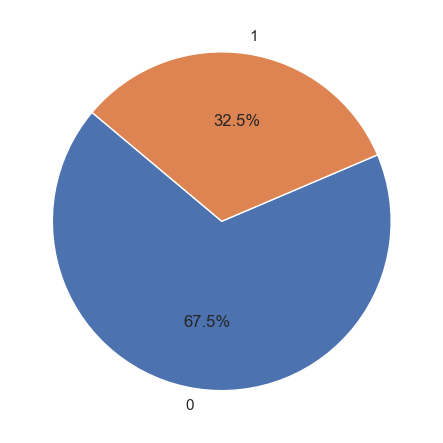

In [119]:
category_ratio= df_poten['is_between_10000_30000'].value_counts()

plt.pie(category_ratio, labels=category_ratio.index, autopct='%1.1f%%', startangle=140)
plt.show()

# 배달 지연 이진 분류

## 데이터 확인

In [120]:
#delivered 물품들의 delivered_date가 결측치인 행의 수

dfd = df[(df['order_status'] == 'delivered') & df['order_delivered_customer_date'].isnull()].shape[0]

print(dfd)

8


In [121]:
# 'order_status'가 'delivered'이고 'order_delivered_customer_date'가 결측치인 행 제거
df_deliver = df[~((df['order_status'] == 'delivered') & df['order_delivered_customer_date'].isnull())]

In [122]:
df_deliver.isnull().sum()

customer_id                         0
customer_unique_id                  0
customer_zip_code_prefix            0
order_id                            0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 176
order_delivered_customer_date    3389
order_estimated_delivery_date       0
total_orders                        0
product_id                        830
seller_id                         830
price                             830
freight_value                     830
total_order_items                   0
payment_sequential                  3
payment_type                        3
payment_installments                3
payment_value                       3
product_category_name            2528
product_weight_g                  850
product_length_cm                 850
product_height_cm                 850
product_width_cm                  850
product_category_name_english    2553
day_of_week                         0
dtype: int64

In [123]:
df_deliver = df_deliver.dropna(subset=['price'])
df_deliver = df_deliver.dropna(subset=['product_weight_g'])
df_deliver = df_deliver.dropna(subset=['payment_sequential'])
df_deliver = df_deliver[df_deliver['order_status'] == 'delivered']
df_deliver = df_deliver.dropna(subset=['product_category_name_english'])
df_deliver = df_deliver.dropna(subset=['order_approved_at'])
df_deliver.isnull().sum() #깔끔 #결측치없음 #성공적

customer_id                      0
customer_unique_id               0
customer_zip_code_prefix         0
order_id                         0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_customer_date    0
order_estimated_delivery_date    0
total_orders                     0
product_id                       0
seller_id                        0
price                            0
freight_value                    0
total_order_items                0
payment_sequential               0
payment_type                     0
payment_installments             0
payment_value                    0
product_category_name            0
product_weight_g                 0
product_length_cm                0
product_height_cm                0
product_width_cm                 0
product_category_name_english    0
day_of_week                      0
dtype: int64

In [124]:
#113361개
df_deliver.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113361 entries, 0 to 118433
Data columns (total 26 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   customer_id                    113361 non-null  object        
 1   customer_unique_id             113361 non-null  object        
 2   customer_zip_code_prefix       113361 non-null  int64         
 3   order_id                       113361 non-null  object        
 4   order_status                   113361 non-null  object        
 5   order_purchase_timestamp       113361 non-null  datetime64[ns]
 6   order_approved_at              113361 non-null  object        
 7   order_delivered_customer_date  113361 non-null  object        
 8   order_estimated_delivery_date  113361 non-null  object        
 9   total_orders                   113361 non-null  int64         
 10  product_id                     113361 non-null  object        
 11  selle

## 모델 생성

In [125]:
df_deliver['order_estimated_delivery_date'] = pd.to_datetime(df_deliver['order_estimated_delivery_date'])
df_deliver['order_delivered_customer_date'] = pd.to_datetime(df_deliver['order_delivered_customer_date'])

df_deliver['delay'] = df_deliver['order_estimated_delivery_date'] - df_deliver['order_delivered_customer_date']

df_deliver['delay']

0         10 days 13:24:25
1          7 days 11:18:41
2        -2 days +06:01:09
3         12 days 07:55:35
4          5 days 03:04:12
                ...       
118429    11 days 03:53:23
118430     8 days 05:05:15
118431   -8 days +04:56:45
118432    18 days 04:01:21
118433    12 days 05:17:24
Name: delay, Length: 113361, dtype: timedelta64[ns]

In [126]:
# 부피도 추가
df_deliver['volume'] = df_deliver['product_height_cm'] * df_deliver['product_length_cm'] * df_deliver['product_width_cm']

In [127]:
df_d = df_deliver.copy()

In [128]:
# 종속, 독립변수로 쓸 columns만 가져오기

df_new = df_deliver[['delay', 'customer_zip_code_prefix', 'order_purchase_timestamp', 'total_orders', 'price', 'freight_value', 'payment_installments', 'payment_type', 'product_weight_g', 'volume', 'product_category_name_english']]

In [129]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113361 entries, 0 to 118433
Data columns (total 11 columns):
 #   Column                         Non-Null Count   Dtype          
---  ------                         --------------   -----          
 0   delay                          113361 non-null  timedelta64[ns]
 1   customer_zip_code_prefix       113361 non-null  int64          
 2   order_purchase_timestamp       113361 non-null  datetime64[ns] 
 3   total_orders                   113361 non-null  int64          
 4   price                          113361 non-null  float64        
 5   freight_value                  113361 non-null  float64        
 6   payment_installments           113361 non-null  float64        
 7   payment_type                   113361 non-null  object         
 8   product_weight_g               113361 non-null  float64        
 9   volume                         113361 non-null  float64        
 10  product_category_name_english  113361 non-null  object       

In [130]:
# 배송 지연을 1, 지연 x를 0으로 설정

def is_negative(td):
    return td.total_seconds() < 0

df_new['delay'] = df_new['delay'].apply(is_negative).astype(int)

In [131]:
df_new['delay'].value_counts()

delay
0    104486
1      8875
Name: count, dtype: int64

In [132]:
# 겹치는 카테고리 합치기

df_new['product_category_name_english'] = df_new['product_category_name_english'].replace({'home_comfort_2': 'home_confort', 'home_appliances_2': 'home_appliances'})

df_new['product_category_name_english'] = df_new['product_category_name_english'].replace({'home_confort': 'home_comfort'})

In [133]:
df_new['product_category_name_english'].unique()

array(['office_furniture', 'housewares', 'home_comfort', 'sports_leisure',
       'computers_accessories', 'toys', 'furniture_decor', 'auto',
       'air_conditioning', 'telephony', 'health_beauty', 'garden_tools',
       'pet_shop', 'bed_bath_table', 'baby', 'watches_gifts',
       'kitchen_dining_laundry_garden_furniture', 'perfumery', 'art',
       'stationery', 'fashio_female_clothing', 'consoles_games',
       'construction_tools_lights', 'food_drink', 'drinks', 'cool_stuff',
       'fashion_bags_accessories', 'home_construction',
       'luggage_accessories', 'electronics', 'home_appliances',
       'fashion_male_clothing', 'small_appliances',
       'small_appliances_home_oven_and_coffee', 'books_general_interest',
       'costruction_tools_tools', 'signaling_and_security',
       'musical_instruments', 'construction_tools_construction', 'music',
       'fashion_shoes', 'industry_commerce_and_business',
       'fashion_underwear_beach', 'dvds_blu_ray',
       'construction_tools

In [134]:
def convert_to_main_category(category_name):
    if category_name in ['garden_tools','la_cuisine', 'construction_tools_lights', 'costruction_tools_garden','small_appliances_home_oven_and_coffee', 'construction_tools_construction', 'costruction_tools_tools', 'home_appliances', 'small_appliances','air_conditioning', 'office_furniture', 'kitchen_dining_laundry_garden_furniture', 'housewares', 'home_comfort', 'furniture_decor', 'bed_bath_table', 'furniture_living_room', 'furniture_bedroom', 'furniture_mattress_and_upholstery', 'home_construction', 'christmas_supplies', 'market_place', 'flowers']:
        return 'Home & Interior'
    elif category_name in ['sports_leisure', 'music', 'fashion_sport', 'toys', 'musical_instruments', 'dvds_blu_ray', 'cds_dvds_musicals']:
        return 'Sports & Leisure'
    elif category_name in ['computers_accessories','electronics','telephony','fixed_telephony','art','arts_and_craftmanship','cine_photo','party_supplies','consoles_games', 'telephony' 'electronics', 'tablets_printing_image', 'cds_dvds_musicals', 'audio', 'computers']:
        return 'Electronics & Computers'
    elif category_name in ['fashio_female_clothing','luggage_accessories', 'watches_gifts', 'fashion_male_clothing', 'fashion_bags_accessories', 'fashion_shoes', 'fashion_underwear_beach', 'fashion_childrens_clothes']:
        return 'Clothing & Accessories'
    elif category_name in ['health_beauty', 'perfumery', 'diapers_and_hygiene']:
        return 'Health & Beauty'
    elif category_name in ['stationery', 'books_general_interest', 'books_technical', 'books_imported']:
        return 'Stationery & Books'
    elif category_name in ['food_drink', 'drinks', 'food']:
        return 'Food & Beverages'
    elif category_name in ['baby', 'pet_shop', 'cool_stuff']:
        return 'Baby & Pet'
    elif category_name in ['signaling_and_security','security_and_services','agro_industry_and_commerce', 'industry_commerce_and_business',
       'construction_tools_safety',]:
        return 'Business'
    elif category_name == 'auto':
        return 'Automotive & Transportation'
    else:
        return 'Others'

# 새로운 상위 카테고리로 변경
df_new['main_category'] = df_new['product_category_name_english'].apply(convert_to_main_category)
df_new

,delay,customer_zip_code_prefix,order_purchase_timestamp,total_orders,price,freight_value,payment_installments,payment_type,product_weight_g,volume,product_category_name_english,main_category
0,0,14409,2022-05-16 15:05:35,1,124.99,21.88,2.0,credit_card,8683.0,107136.0,office_furniture,Home & Interior
1,0,9790,2023-01-12 20:48:24,1,289.00,46.48,8.0,credit_card,10150.0,53400.0,housewares,Home & Interior
2,1,1151,2023-05-19 16:07:45,1,139.94,17.79,7.0,credit_card,8267.0,45968.0,office_furniture,Home & Interior
3,0,8775,2023-03-13 16:06:38,1,149.94,23.36,1.0,credit_card,12160.0,79968.0,office_furniture,Home & Interior
4,0,13056,2023-07-29 09:51:30,1,230.00,22.25,8.0,credit_card,5200.0,23625.0,home_comfort,Home & Interior
...,...,...,...,...,...,...,...,...,...,...,...,...
118429,0,3937,2023-04-07 15:48:17,1,74.90,13.88,6.0,credit_card,611.0,11132.0,books_general_interest,Stationery & Books
118430,0,6764,2023-04-04 08:20:22,1,114.90,14.16,3.0,credit_card,1211.0,13200.0,sports_leisure,Sports & Leisure
118431,1,60115,2023-04-08 20:11:50,1,37.00,19.04,5.0,credit_card,870.0,9000.0,health_beauty,Health & Beauty
118432,0,92120,2022-11-03 21:08:33,1,689.00,22.07,2.0,credit_card,710.0,3458.0,watches_gifts,Clothing & Accessories


[피처 엔지니어링]

+ zip_code : 10분위 구간화
+ 구매시각 : zip_code : 10분위 구간화
+ 가격 : zip_code : 10분위 구간화
+ 배송비 : zip_code : 10분위 구간화
+ 무게, 부피 : zip_code : 10분위 구간화
+ 결제방식 : credit 0, boleto 1, voucher 2, debit 3
+ 카테고리 : 0-9 labeling

In [135]:
df_new['customer_zip_code_prefix'] = pd.qcut(df_new['customer_zip_code_prefix'], q=10, labels=range(10))
df_new['order_purchase_timestamp'] = pd.to_datetime(df_new['order_purchase_timestamp'])
df_new['order_purchase_timestamp'] = pd.qcut(df_new['order_purchase_timestamp'], q=10, labels=range(10))
df_new['total_orders'] = df_new['total_orders']
df_new['price'] = pd.qcut(df_new['price'], q=10, labels=range(10))
df_new['product_weight_g'] = pd.qcut(df_new['product_weight_g'], q=10, labels=range(10))
df_new['freight_value'] = pd.qcut(df_new['freight_value'], q=10, labels=range(10))
df_new['volume'] = pd.qcut(df_new['volume'], q=10, labels=range(10))
df_new['payment_type'] = df_new['payment_type'].map({'credit_card': 0, 'boleto': 1, 'voucher':2, 'debit_card':3})

df_new['main_category'] = df_new['main_category'].map({'Home & Interior': 0, 'Sports & Leisure': 1,'Electronics & Computers':2, 'Clothing & Accessories':3, 'Health & Beauty':4, 'Stationery & Books':5, 'Food & Beverages':6,'Baby & Pet':7, 'Business':8,'Automotive & Transportation':9})

df_new

,delay,customer_zip_code_prefix,order_purchase_timestamp,total_orders,price,freight_value,payment_installments,payment_type,product_weight_g,volume,product_category_name_english,main_category
0,0,3,0,1,7,7,2.0,0,9,9,office_furniture,0
1,0,2,4,1,9,9,8.0,0,9,9,housewares,0
2,1,0,7,1,7,5,7.0,0,9,9,office_furniture,0
3,0,2,6,1,7,8,1.0,0,9,9,office_furniture,0
4,0,2,9,1,9,7,8.0,0,8,8,home_comfort,0
...,...,...,...,...,...,...,...,...,...,...,...,...
118429,0,0,6,1,4,2,6.0,0,4,6,books_general_interest,5
118430,0,1,6,1,6,3,3.0,0,6,6,sports_leisure,1
118431,1,7,6,1,2,6,5.0,0,5,5,health_beauty,4
118432,0,9,3,1,9,7,2.0,0,5,3,watches_gifts,3


In [136]:
df_new.drop('product_category_name_english', axis=1, inplace=True)

In [137]:
df_copy = df_new.copy()
df_copy

,delay,customer_zip_code_prefix,order_purchase_timestamp,total_orders,price,freight_value,payment_installments,payment_type,product_weight_g,volume,main_category
0,0,3,0,1,7,7,2.0,0,9,9,0
1,0,2,4,1,9,9,8.0,0,9,9,0
2,1,0,7,1,7,5,7.0,0,9,9,0
3,0,2,6,1,7,8,1.0,0,9,9,0
4,0,2,9,1,9,7,8.0,0,8,8,0
...,...,...,...,...,...,...,...,...,...,...,...
118429,0,0,6,1,4,2,6.0,0,4,6,5
118430,0,1,6,1,6,3,3.0,0,6,6,1
118431,1,7,6,1,2,6,5.0,0,5,5,4
118432,0,9,3,1,9,7,2.0,0,5,3,3


In [138]:
# 수치형->10분위 / 범주형: 라벨만 붙여줌

from datetime import datetime

def predict_delay(model, scaler, customer_zip_code_prefix, order_purchase_timestamp, total_orders, price, freight_value, product_weight_g, volume, payment_type, main_category, payment_sequential):
    # 문자열 형태의 날짜를 datetime 객체로 변환
    purchase_date = datetime.strptime(order_purchase_timestamp, '%Y-%m-%d %H:%M:%S')
    
    # 입력 데이터 생성
    input_data = pd.DataFrame({
        'customer_zip_code_prefix' : [customer_zip_code_prefix],
        'order_purchase_timestamp' : [order_purchase_timestamp], #[(purchase_date.year - 2000) * 12 + purchase_date.month], #또 해야 되나?
        'total_orders' : [total_orders],
        'price' : [price],
        'freight_value' : [freight_value], 
        'product_weight_g' : [product_weight_g],
        'volume' : [volume],
        'payment_type' : [0 if payment_type == 'credit_card' else (1 if payment_type == 'boleto' else(2 if payment_type == 'voucher' else(3 if payment_type == 'debit_card' else None)))],
        'main_category' : [0 if main_category =='Home & Interior' else(1 if main_category == 'Sports & Leisure' else(2 if main_category == 'Electronics & Computers' else(3 if main_category == 'Clothing & Accessories' else(4 if main_category == 'Health & Beauty' else(5 if main_category == 'Stationery & Books' else(6 if main_category == 'Food & Beverages' else(7 if main_category =='Baby & Pet' else(8 if main_category == 'Business' else(9 if main_category =='Automotive & Transportation' else None)))))))))],
        'payment_sequential' : [payment_sequential]
    })

    
    # 'customer_zip_code_prefix' 범주화
    zip_bins = pd.qcut(df_copy['customer_zip_code_prefix'], 9, retbins=True)[1] 
    input_data['customer_zip_code_prefix'] = pd.cut(input_data['customer_zip_code_prefix'], bins=zip_bins, labels=False, include_lowest=True)
    # 'order_purchase_timestamp' 범주화
    purchase_bins = pd.qcut(df_copy['order_purchase_timestamp'], 9, retbins=True)[1] 
    input_data['order_purchase_timestamp'] = pd.cut(input_data['order_purchase_timestamp'], bins=purchase_bins, labels=False, include_lowest=True)
    # 'price' 범주화
    price_bins = pd.qcut(df_copy['price'], 9, retbins=True)[1] 
    input_data['price'] = pd.cut(input_data['price'], bins=price_bins, labels=False, include_lowest=True)
    # 'freight_value' 범주화
    freight_bins = pd.qcut(df_copy['freight_value'], 9, retbins=True)[1] 
    input_data['freight_value'] = pd.cut(input_data['freight_value'], bins=freight_bins, labels=False, include_lowest=True)
    # 'product_weight_g' 범주화
    prod_weight_bins = pd.qcut(df_copy['product_weight_g'], 9, retbins=True)[1] 
    input_data['product_weight_g'] = pd.cut(input_data['product_weight_g'], bins=prod_weight_bins, labels=False, include_lowest=True)
    # 'volume' 범주화
    volume_bins = pd.qcut(df_copy['volume'], 9, retbins=True)[1] 
    input_data['volume'] = pd.cut(input_data['volume'], bins=volume_bins, labels=False, include_lowest=True)
    
   
    # 입력 데이터를 스케일링합니다.
    input_data_scaled = scaler.transform(input_data)

    # 예측을 수행합니다.
    prediction = model.predict(input_data_scaled)
    prediction_proba = model.predict_proba(input_data_scaled)

    # 예측 결과와 확률을 반환합니다.
    result = 'delay' if prediction == 1 else 'not delay'
    probability = prediction_proba[0][int(prediction)]

    return result, probability



In [139]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 113361 entries, 0 to 118433
Data columns (total 11 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   delay                     113361 non-null  int32   
 1   customer_zip_code_prefix  113361 non-null  category
 2   order_purchase_timestamp  113361 non-null  category
 3   total_orders              113361 non-null  int64   
 4   price                     113361 non-null  category
 5   freight_value             113361 non-null  category
 6   payment_installments      113361 non-null  float64 
 7   payment_type              113361 non-null  int64   
 8   product_weight_g          113361 non-null  category
 9   volume                    113361 non-null  category
 10  main_category             113361 non-null  int64   
dtypes: category(6), float64(1), int32(1), int64(3)
memory usage: 5.4 MB


In [140]:
X = df_new.drop('delay', axis = 1)
X

,customer_zip_code_prefix,order_purchase_timestamp,total_orders,price,freight_value,payment_installments,payment_type,product_weight_g,volume,main_category
0,3,0,1,7,7,2.0,0,9,9,0
1,2,4,1,9,9,8.0,0,9,9,0
2,0,7,1,7,5,7.0,0,9,9,0
3,2,6,1,7,8,1.0,0,9,9,0
4,2,9,1,9,7,8.0,0,8,8,0
...,...,...,...,...,...,...,...,...,...,...
118429,0,6,1,4,2,6.0,0,4,6,5
118430,1,6,1,6,3,3.0,0,6,6,1
118431,7,6,1,2,6,5.0,0,5,5,4
118432,9,3,1,9,7,2.0,0,5,3,3


In [141]:
y = df_new['delay']
y

0         0
1         0
2         1
3         0
4         0
         ..
118429    0
118430    0
118431    1
118432    0
118433    0
Name: delay, Length: 113361, dtype: int32

In [142]:
# sklearn.model_selectio의 train_test_split 함수를 import 해주세요.
from sklearn.model_selection import train_test_split
# tran_test_split 함수를 이용하여 독립변수(X)와 종속변수(y)를 각각 훈련 세트와 테스트 세트로 나누어주세요. 각 훈련 세트와 테스트 세트의 변수 명은 아래와 같습니다.
# 독립변수 훈련 세트: X_train, 독립변수 테스트 세트: X_test, 종속변수 훈련 세트: y_train, 종속변수 테스트 세트: y_test
# 단, random_state는 42로 합니다.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [143]:
print("len(X_train): ",len(X_train))
print("len(X_test): ",len(X_test))
print("len(X_test)/(len(X_train)+len(X_test))",len(X_test)/(len(X_train)+len(X_test)))

len(X_train):  90688
len(X_test):  22673
len(X_test)/(len(X_train)+len(X_test)) 0.20000705710076658


In [144]:
# sklearn.preprocessing에서 MinMaxScaler를 import 해옵니다.
from sklearn.preprocessing import MinMaxScaler
# scaler라는 변수를 MinMaxScaler 함수로 선언합니다.
scaler = MinMaxScaler()
# X_train_scaled라는 변수에 스케일링된 독립변수 훈련 세트를 저장합니다.
X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled라는 변수에 스케일링된 독립변수 테스트 세트를 저장합니다.
X_test_scaled = scaler.transform(X_test)

In [145]:
# sklearn.linear_model에서 LogisticRegression 함수를 import 해오세요.
from sklearn.linear_model import LogisticRegression
# lr_model을 변수명으로 해서 로지스틱회귀 모델 객체를 생성하세요.
lr_model = LogisticRegression()

In [146]:
lr_model.fit(X_train_scaled, y_train)

LogisticRegression()

In [147]:
lr_model.score(X_train_scaled, y_train)

0.9217426781933663

In [148]:
y_pred = lr_model.predict(X_test_scaled)

In [149]:
# sklearn.metrics에서 confusion_matrix를 import 해옵니다.
from sklearn.metrics import confusion_matrix

# 실제 타겟(y_test)과 예측 타겟(y_pred)을 사용하여 혼동 행렬 생성해서, conf_matrix 변수에 저장해주세요.
conf_matrix = confusion_matrix(y_test, y_pred)

In [150]:
print(conf_matrix)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')

[[20895     0]
 [ 1778     0]]
True Negatives: 20895
False Positives: 0
False Negatives: 1778
True Positives: 0


In [151]:
# sklearn.metrics에서 accuracy_score를 import 해오세요.
from sklearn.metrics import accuracy_score

# accuracy 변수에 정확도를 저장해주세요.
accuracy = accuracy_score(y_test, y_pred)

In [152]:
print(f'로지스틱회귀 모델의 정확도: {accuracy}')

로지스틱회귀 모델의 정확도: 0.9215807347946897


In [153]:
# sklearn.metrics에서 classification_report를 import 해오세요.
from sklearn.metrics import classification_report

# report 변수에 분류 보고서를 저장하세요.
report = classification_report(y_test, y_pred)

In [154]:
print(f'[ 분류 보고서 ]\n {report}')

[ 분류 보고서 ]
               precision    recall  f1-score   support

           0       0.92      1.00      0.96     20895
           1       0.00      0.00      0.00      1778

    accuracy                           0.92     22673
   macro avg       0.46      0.50      0.48     22673
weighted avg       0.85      0.92      0.88     22673



# 분류 MODEL1

In [156]:
import statsmodels.api as sm

# 독립 변수와 종속 변수 설정

X = df_new[['customer_zip_code_prefix', 'order_purchase_timestamp', 'total_orders', 'price', 'freight_value', 
                  'payment_installments', 'payment_type', 'product_weight_g', 'volume', 'main_category']]
y = df_new['delay']

# 상수항(절편) 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 결과 요약
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.272329
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  delay   No. Observations:               113361
Model:                          Logit   Df Residuals:                   113350
Method:                           MLE   Df Model:                           10
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                0.008170
Time:                        18:05:48   Log-Likelihood:                -30871.
converged:                       True   LL-Null:                       -31126.
Covariance Type:            nonrobust   LLR p-value:                6.390e-103
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8711      0.056    -50.826      0.000      -2.982

In [157]:
from sklearn.metrics import classification_report

# 모델 예측값 생성

# classification_report를 사용하여 보고서 생성
report = classification_report(y_test, y_pred, output_dict=True)

# macro 평균 F1-score 출력
macro_f1_score = report['macro avg']['f1-score']
print("Macro 평균 F1-score:", macro_f1_score)


Macro 평균 F1-score: 0.479595115681234


In [158]:
from sklearn.metrics import f1_score

y_pred = result.predict(X) > 0.5 

# weighted average F1 score 계산
weighted_f1_score = f1_score(y, y_pred, average='weighted')
print("Weighted Average F1 score:", weighted_f1_score)

Weighted Average F1 score: 0.8841601783885876


# 분류 Model 2 

In [159]:
import statsmodels.api as sm

# 독립 변수와 종속 변수 설정
X = df_new[['customer_zip_code_prefix', 'price', 'freight_value', 'volume']]
y = df_new['delay']


# 상수항(절편) 추가
X = sm.add_constant(X)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y, X)
result = logit_model.fit()

# 결과 요약
print(result.summary())


Optimization terminated successfully.
         Current function value: 0.272904
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  delay   No. Observations:               113361
Model:                          Logit   Df Residuals:                   113356
Method:                           MLE   Df Model:                            4
Date:                Thu, 04 Apr 2024   Pseudo R-squ.:                0.006075
Time:                        18:06:17   Log-Likelihood:                -30937.
converged:                       True   LL-Null:                       -31126.
Covariance Type:            nonrobust   LLR p-value:                 1.434e-80
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -2.8525      0.030    -94.058      0.000      -2.912

In [160]:
from sklearn.metrics import classification_report


y_pred = result.predict(X) > 0.5

report = classification_report(y, y_pred, output_dict=True)

# macro 평균 F1-score 계산
macro_f1_score = report['macro avg']['f1-score']
print("Macro 평균 F1-score:", macro_f1_score)


Macro 평균 F1-score: 0.4796301991764862


In [161]:
from sklearn.metrics import f1_score

y_pred = result.predict(X) > 0.5 

# weighted average F1 score 계산
weighted_f1_score = f1_score(y, y_pred, average='weighted')
print("Weighted Average F1 score:", weighted_f1_score)

Weighted Average F1 score: 0.8841601783885876


# 분류 Model 3 - decision tree

In [162]:
# sklearn.tree에서 DecisionTreeClassifier를 import 해오세요.
from sklearn.tree import DecisionTreeClassifier

# tree_model이라는 변수에 의사 결정 나무 모델을 생성해주세요. 단, random_state는 42로 합니다.
tree_model = DecisionTreeClassifier(random_state=42)
# 모델 학습
tree_model.fit(X_train_scaled, y_train)

# 예측 결과 생성
tree_pred = tree_model.predict(X_test_scaled)

# 혼동 행렬 생성
tn, fp, fn, tp = confusion_matrix(y_test, tree_pred).ravel()
print(f'True Negatives: {tn}')
print(f'False Positives: {fp}')
print(f'False Negatives: {fn}')
print(f'True Positives: {tp}')

# 정확도 측정
tree_accuracy = accuracy_score(y_test, tree_pred)
print("Decision Tree 모델의 정확도:", tree_accuracy)

# 분류 보고서 생성
tree_report = classification_report(y_test, tree_pred)
print(tree_report)



True Negatives: 19453
False Positives: 1442
False Negatives: 1224
True Positives: 554
Decision Tree 모델의 정확도: 0.8824152075155471
              precision    recall  f1-score   support

           0       0.94      0.93      0.94     20895
           1       0.28      0.31      0.29      1778

    accuracy                           0.88     22673
   macro avg       0.61      0.62      0.61     22673
weighted avg       0.89      0.88      0.89     22673



In [163]:
from sklearn.metrics import classification_report

# 모델 예측
tree_pred = tree_model.predict(X_test_scaled)

# 분류 보고서 생성
tree_report = classification_report(y_test, tree_pred, output_dict=True)

# macro average F1-score 출력
macro_f1_score = tree_report['macro avg']['f1-score']
print("Macro average F1-score:", macro_f1_score)

# Weighted average F1-score 출력
weighted_f1_score = tree_report['weighted avg']['f1-score']
print("Weighted average F1-score:", weighted_f1_score)


Macro average F1-score: 0.614729001333956
Weighted average F1-score: 0.8855029683995933
